# Miscellaneous COVID-19 Data Analyses using Johns Hopkins Data

Data sources: 

- <a href="https://github.com/CSSEGISandData/COVID-19" target="_blank">Johns Hopkins University's Center for Systems Science and Engineering (CSSE) COVID-19 data repository</a>
- <a href="https://worldpopulationreview.com/states/" target="_blank">World Population Review</a> (for state population data).

The most up-to-date version of this notebook can be found in GitHub repository [bmc/covid19](https://github.com/bmc/covid19/).


## Imports and constants

In [1]:
import matplotlib
import matplotlib.pyplot as p
import numpy as np
import pandas as pd
from datetime import datetime, timedelta, date
import csv
import os
import sys
import re
import math
from pprint import pprint
from enum import Enum
from itertools import chain
from collections import namedtuple
import functools
from lib.common import *

print(f"Using Python {sys.version_info.major}.{sys.version_info.minor}.{sys.version_info.micro}")
print(f"Using matplotlib {matplotlib.__version__}")
print(f"Using Pandas {pd.__version__}")

Using Python 3.8.4
Using matplotlib 3.2.2
Using Pandas 1.0.5


In [2]:
JOHNS_HOPKINS_DIR_PATH = 'data/johns-hopkins/COVID-19/csse_covid_19_data/csse_covid_19_daily_reports_us'

In [3]:
os.makedirs(IMAGES_PATH, exist_ok=True)
today = datetime.now().date()

## Helpers

In [4]:
# Read the data into a single Pandas DataFrame
def read_all_into_pandas():
    """
    Read all CSV files into a single Pandas DataFrame.
    
    Note:

    - The date (which is the file name) is added as column "Date",
      as a Python date object.
    - The date is also transformed into a month/year string (e.g.
      "07/02") and stored in column "Month_Day"
    
    The DataFrame will be sorted by date.
    """
    f_pat = re.compile(r'^([01]\d-[0123]\d-202\d)\.csv')
    data_frames = []
    for f in os.listdir(JOHNS_HOPKINS_DIR_PATH):
        # Skip any file that doesn't match the regex. It'd
        # probably be sufficient to check the extension, but
        # this approach is more robust.
        m = f_pat.match(f)
        if m is None:
            continue
        df = pd.read_csv(os.path.join(JOHNS_HOPKINS_DIR_PATH, f))
        df['Date'] = m.group(1)
        # Now, convert to Pandas datetime. You can't store a regular
        # Python date or datetime in Pandas and then operate on it
        # using Pandas datetime functions. It has to be a Pandas
        # datetime.
        df['Date'] = pd.to_datetime(df['Date'], format='%m-%d-%Y')
        df['Month_Day'] = df['Date'].dt.strftime('%m/%d')
        data_frames.append(df)

    final_df = pd.concat(data_frames, ignore_index=True)
    final_df.sort_values(by=['Date'], inplace=True)
    return final_df

In [151]:
METRIC_COLUMNS = {
    MetricType.DEATHS: 'Deaths',
    MetricType.CASES: 'Confirmed',
    MetricType.RECOVERIES: 'Recovered',
    MetricType.HOSPITALIZATIONS: 'People_Hospitalized',
    MetricType.TESTED: 'People_Tested',
}

METRIC_LABELS = {
    MetricType.DEATHS: 'Deaths',
    MetricType.CASES: 'Cases',
    MetricType.RECOVERIES: 'Recoveries',
    MetricType.HOSPITALIZATIONS: 'Hospitalizations',
    MetricType.TESTED: 'Tested',        
}

METRIC_COLORS = {
    MetricType.DEATHS: 'red',
    MetricType.CASES: 'blue',
    MetricType.RECOVERIES: 'cyan',
    MetricType.HOSPITALIZATIONS: 'green',
    MetricType.TESTED: 'black',        
}

In [152]:
def plot_stats_by_date(df, metrics={MetricType.DEATHS}, per_n=1, population=None,
                       textbox_heading=None, textbox_loc=None, marker=None, 
                       figsize=(20, 12), image_file=None):
    """
    Takes a Pandas DataFrame with the Johns Hopkins data, groups the
    data by 'Month_Day' and sums up the values for all metrics. Then,
    plots the results. If an image file is specified, saves the plot in
    the appropriate image.
    
    Parameters:
    
    df              - The Pandas DataFrame to plot
    metrics         - A set containing the metrics to plot. Defaults to deaths.
    per_n           - If set to 1, plot the data as is. Otherwise, do a per-capita
                      plot (i.e., number of X per n people). If per_n is not 1,
                      then population must be defined.
    population      - The population of the area (state, country) being plotted.
                      Only necessary if per_n is greater than 1.
    figsize         - The size of the plot.
    marker          - matplotlib marker to use for data points, or None.
    textbox_heading - An optional heading to add to the textbox annotation
    textbox_loc     - An (x, y) tuple for the location of the text box's top
                      left corner. Defaults to the upper left.
    image_file      - Name of image file in which to save plot, or None.
    """
    assert (per_n == 1) or (population is not None)

    FirstLast = namedtuple('FirstLast', ('first', 'last'))

    def maybe_plot_metric(m, ax, df, first_last, errors):
        """
        Given a particular metric, calculate the appropriate data
        and, if the metric was specified, plot it.
        
        Parameters:
        m          - the metric (e.g., MetricType.DEATHS)
        ax         - the plot axis to use
        df         - the DataFrame to query
        first_last - the dictionary containing first and last values
                     for each metric. The key is a MetricType. The
                     value is a FirstLast object. The first and last
                     values for all metrics will be added here, even
                     if the metric isn't plotted.
        errors     - an array to which error messages can be appended
        """
        col = METRIC_COLUMNS[m]

        # Group the DataFrame by 'Month_Day', and sum up
        # the metric value. That gives us a grouping that sums
        # that value for all values for a given week. If the
        # DataFrame contains multiple state values, then they'll
        # all be summed up.
        group = df[col].groupby(df['Month_Day']).sum()

        if per_n > 1:
            group = group.apply(lambda sum: get_per_capita_int(sum, population))

        group_df = group.to_frame()
        first_value = int(round(group_df[col].iloc[0]))
        last_value = int(round(group_df[col].iloc[-1]))
        first_last[m] = FirstLast(first=first_value, last=last_value)

        if m in metrics:
            # Since these values are cumulative, if the last value is 0, we
            # can't trust the data.
            last_val = group_df[col].iloc[-1]
            if last_val <= 0:
                errors.append(f"No data for {METRIC_LABELS[m]} in this data set.")
            else:
                group.plot(x='Month_Day', y=col, ax=ax, figsize=figsize, color=METRIC_COLORS[m], marker=marker)

        return
    
    def build_text_for_texbox(first_last, start_date, end_date):
        """
        Builds the text block that will fill the explanatory
        text box in the plot.
        
        Parameters:
        
        first_last - the dictionary containing first and last values
                     for each metric. The key is a MetricType. The
                     value is a FirstLast object.
        start_date - the starting date, formatted as a string
        end_date   - the ending date, formatted as a string                     
        """
        def metric_summary_text(metric, first_last_dict, date_start, date_end):
            fl = first_last_dict[metric]
            label = METRIC_LABELS[metric]
            return f"{label}: {fl.first:,} ({date_start}) to {fl.last:,} ({date_end})"

        heading = f"{textbox_heading}: " if textbox_heading else ""
        text_lines = [f"{heading}{start_date} to {end_date}"]
        text_lines.append("\nValues represent running totals as of each\n"
                          "week, not totals just for that week.")
        if per_n > 1:
            text_lines.append(f"All numbers are per {per_n:,} people.")

        # Don't include hospitalizations, recoveries, or tested totals unless
        # they're in the metrics. This avoids cluttering up the textbox.

        text_lines.append("")
        text_lines.append(metric_summary_text(MetricType.DEATHS, first_last, start_date, end_date))
        text_lines.append(metric_summary_text(MetricType.CASES, first_last, start_date, end_date))
        if MetricType.RECOVERIES in metrics:
            text_lines.append(metric_summary_text(MetricType.RECOVERIES, first_last, start_date, end_date))
        if MetricType.HOSPITALIZATIONS in metrics:
            text_lines.append(metric_summary_text(MetricType.HOSPITALIZATIONS, first_last, start_date, end_date))
        if MetricType.TESTED in metrics:
            text_lines.append(metric_summary_text(MetricType.TESTED, first_last, start_date, end_date))
        
        return '\n'.join(text_lines)

    # Main logic

    first_last = dict()
    errors = []

    # Make sure the DataFrame is sorted by Date, in case
    # it's been changed. Don't sort in place, though. Leave the 
    # original as is.
    df_by_date = df.sort_values(by=['Date'], inplace=False)

    fig, ax = p.subplots(figsize=figsize)

    for m in MetricType:
        maybe_plot_metric(m, ax, df_by_date, first_last, errors)

    if len(metrics) > 1:
        ax.legend(loc='upper center')

    x_label = """Week

(Source: Johns Hopkins University Center for Systems Science and Engineering)"""
    ax.set_xlabel(x_label)

    y_label = ', '.join(METRIC_LABELS[m] for m in metrics)
    if per_n > 1:
        y_label = f"{y_label} per {per_n:,} people"
    ax.set_ylabel(y_label)

    # Build the explanatory text box.
    if len(errors) > 0:
        text_lines = ["ERROR: Can't plot all requested metrics.\n"]
        text_lines.extend(errors)
        text = '\n'.join(text_lines)
    else:
        start_date = df_by_date['Date'].iloc[0].date().strftime('%B %d')
        end_date = df_by_date['Date'].iloc[-1].date().strftime('%B %d')
        text = build_text_for_texbox(first_last, start_date, end_date)

    text_x, text_y = textbox_loc or (0.01, 0.98)
    textbox(ax, text_x, text_y, text)

    # Save the plot, if desired.
    if image_file is not None:
        fig.savefig(os.path.join(IMAGES_PATH, image_file))

    return None

## Read the data

### Load the state population data

In [7]:
populations = load_united_states_population_data()
print(f"{populations['United States']:,}")

334,351,157


### Load the Johns Hopkins data

In [9]:
df = read_all_into_pandas()

In [10]:
df

,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,FIPS,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,UID,ISO3,Testing_Rate,Hospitalization_Rate,Date,Month_Day
2039,Alaska,US,2020-04-12 23:18:15,61.3707,-152.4044,272,8,66.0,264.0,2.0,45.504049,8038.0,31.0,2.941176,84000002.0,USA,1344.711576,11.397059,2020-04-12,04/12
2066,Missouri,US,2020-04-12 23:18:15,38.4561,-92.2884,4269,118,NaN,4151.0,29.0,72.856593,45200.0,988.0,2.764113,84000029.0,USA,771.402670,23.143593,2020-04-12,04/12
2065,Mississippi,US,2020-04-12 23:18:15,32.7416,-89.6787,2781,96,NaN,2685.0,28.0,96.055341,21413.0,548.0,3.451996,84000028.0,USA,739.601949,19.705142,2020-04-12,04/12
2064,Minnesota,US,2020-04-12 23:18:15,45.6945,-93.9002,1621,70,842.0,1551.0,27.0,32.771004,37421.0,361.0,4.318322,84000027.0,USA,756.522966,22.270204,2020-04-12,04/12
2063,Michigan,US,2020-04-12 23:18:15,43.3266,-84.5361,24244,1479,433.0,22765.0,26.0,304.295367,79437.0,3636.0,6.100478,84000026.0,USA,997.043023,14.997525,2020-04-12,04/12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5088,Michigan,US,2020-07-23 05:15:18,43.3266,-84.5361,83730,6388,55162.0,22180.0,26.0,838.401912,1559613.0,NaN,7.629285,84000026.0,USA,15616.654970,NaN,2020-07-22,07/22
5089,Minnesota,US,2020-07-23 05:15:18,45.6945,-93.9002,47961,1592,42234.0,4135.0,27.0,850.427829,888551.0,4771.0,3.319364,84000027.0,USA,15755.478372,9.947666,2020-07-22,07/22
5090,Mississippi,US,2020-07-23 05:15:18,32.7416,-89.6787,47071,1423,30315.0,15333.0,28.0,1581.607641,403030.0,3844.0,3.023093,84000028.0,USA,13541.996721,8.166387,2020-07-22,07/22
5092,Montana,US,2020-07-23 05:15:18,46.9219,-110.4544,2812,42,1543.0,1227.0,30.0,263.104218,143518.0,179.0,1.493599,84000030.0,USA,13428.232991,6.365576,2020-07-22,07/22


In [11]:
jhu_starting_date = df['Date'].min().date()
jhu_ending_date = df['Date'].max().date()
# See https://stackoverflow.com/a/15411596
total_unique_dates = len(df.groupby('Date').Date.nunique())
print(f"Loaded data for {total_unique_dates} weeks.")
# len(dataframe.index) is the idiom for getting the number of rows.
print(f"Total rows: {len(df.index):,}")
print(f"Starting date: {datestr(jhu_starting_date, include_year=True)}")
print(f"Ending date: {datestr(jhu_ending_date, include_year=True)}")

Loaded data for 102 weeks.
Total rows: 5,934
Starting date: 04/12/2020
Ending date: 07/22/2020


## Deaths across the US

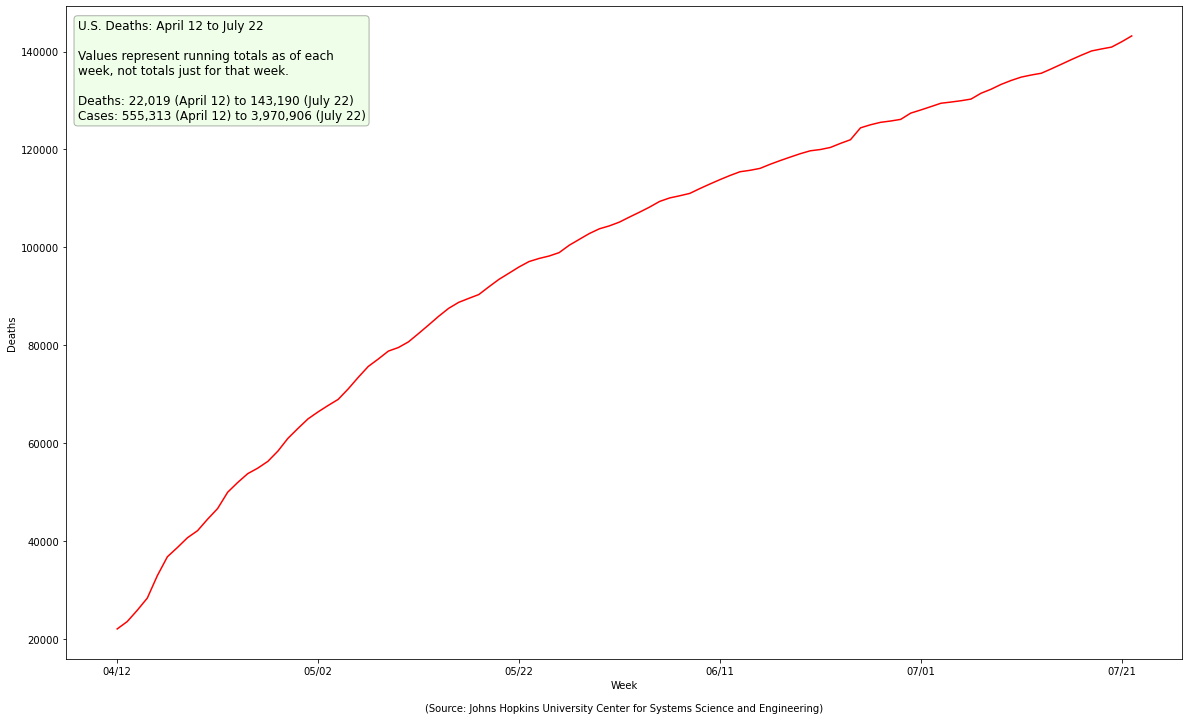

In [153]:
plot_stats_by_date(df, metrics={MetricType.DEATHS}, image_file='jhu-us-deaths.png', textbox_heading="U.S. Deaths")

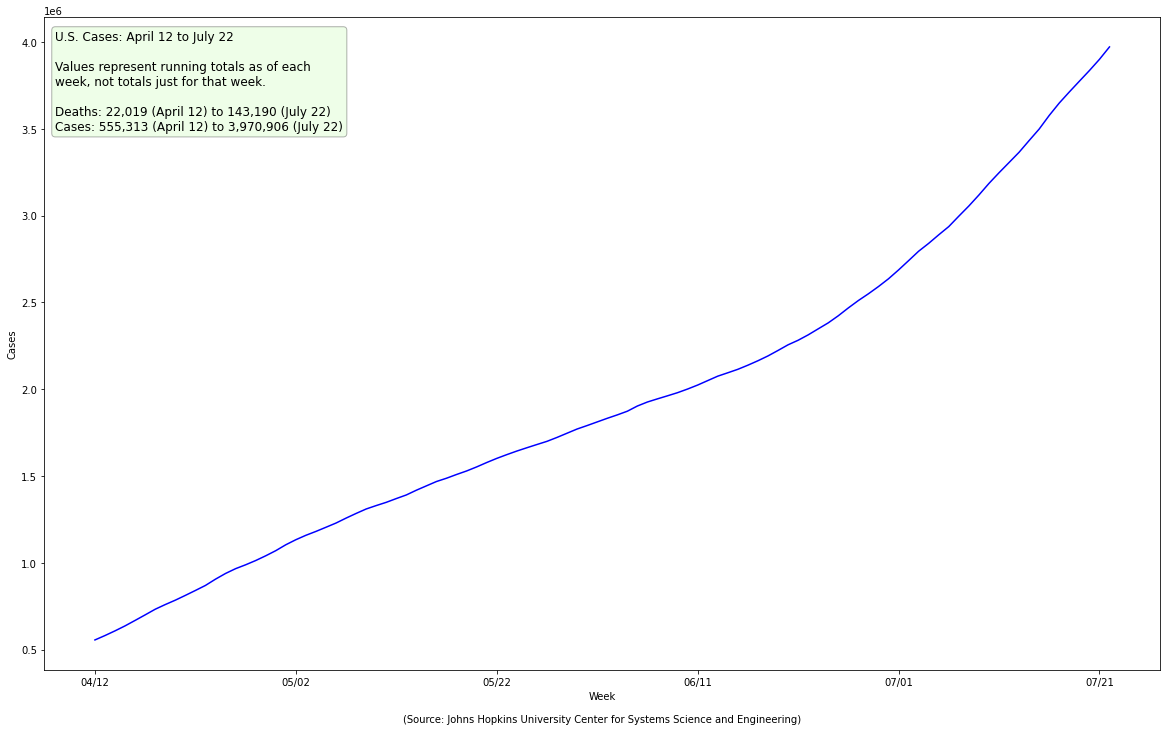

In [13]:
plot_stats_by_date(df, metrics={MetricType.CASES}, image_file='jhu-us-cases.png', textbox_heading="U.S. Cases")

### Just the past week

In [14]:
week_delta = timedelta(days=6)
six_days_prior = jhu_ending_date - week_delta
last_week_start = date_to_datetime(six_days_prior)
last_week_end = date_to_datetime(jhu_ending_date, hour=23, minute=59, second=59)

df_past_week = df.loc[(df['Date'] >= last_week_start) & (df['Date'] <= last_week_end)]

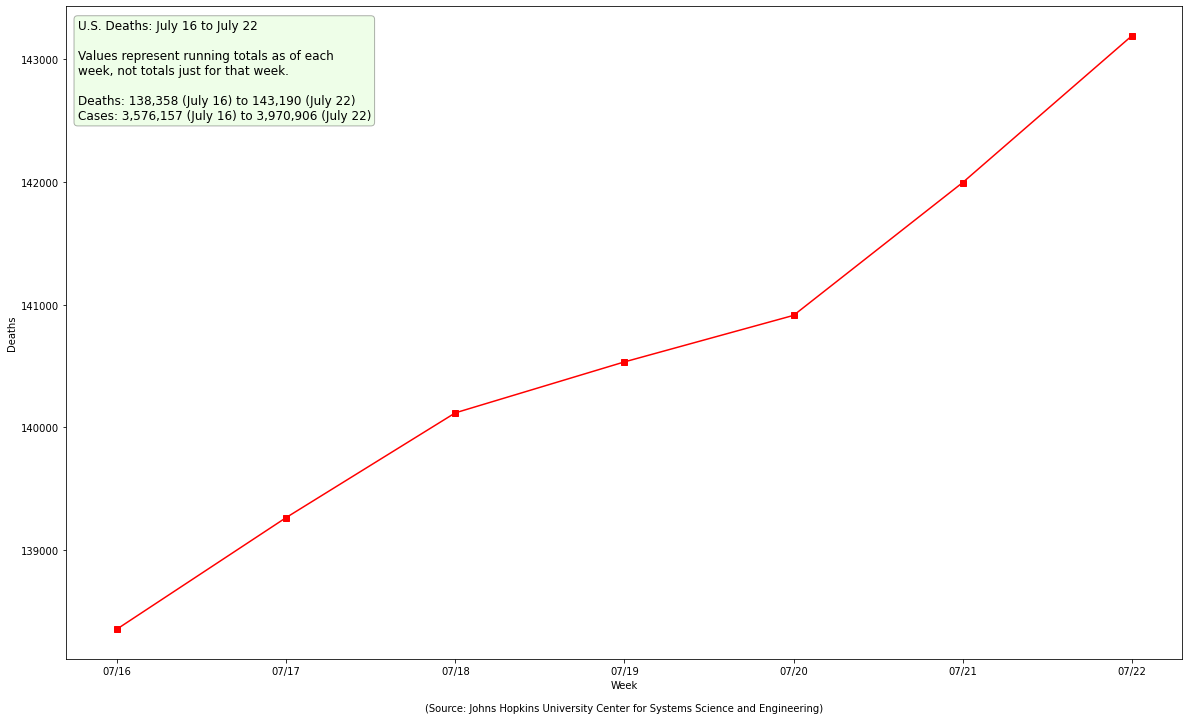

In [15]:
plot_stats_by_date(df_past_week, metrics={MetricType.DEATHS}, marker='s', 
                   textbox_heading="U.S. Deaths", image_file='jhu-us-deaths-past-week.png')

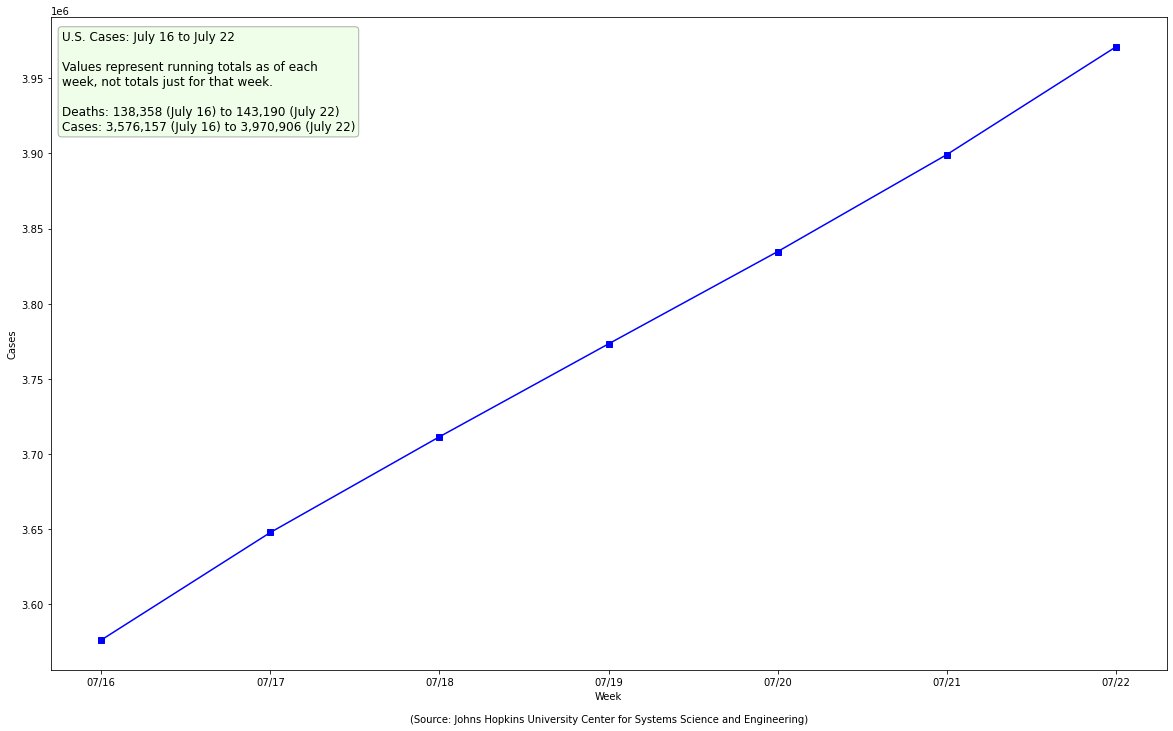

In [16]:
plot_stats_by_date(df_past_week, metrics={MetricType.CASES}, marker='s', 
                   textbox_heading="U.S. Cases", image_file='jhu-us-cases-past-week.png')

## Deaths vs. Cases

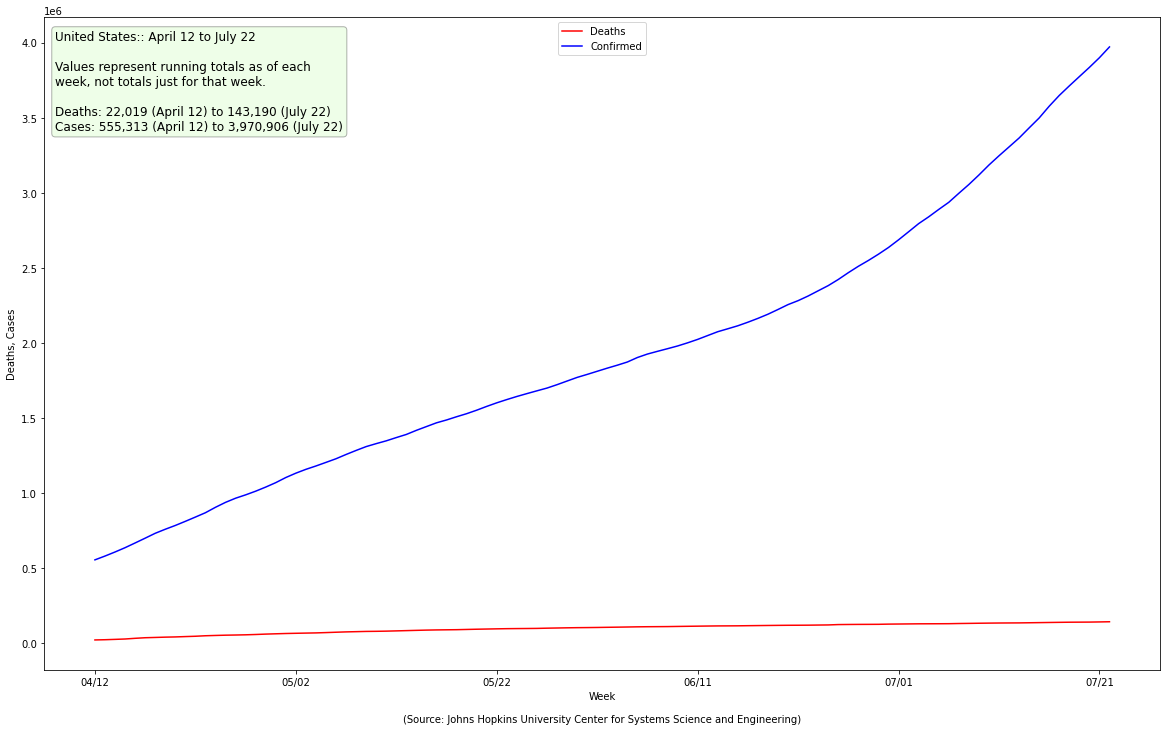

In [17]:
plot_stats_by_date(df, metrics={MetricType.DEATHS, MetricType.CASES}, textbox_heading="United States:",
                   image_file="jhu-us-deaths-and-cases.png")

## Individual States

#### Pennsylvania

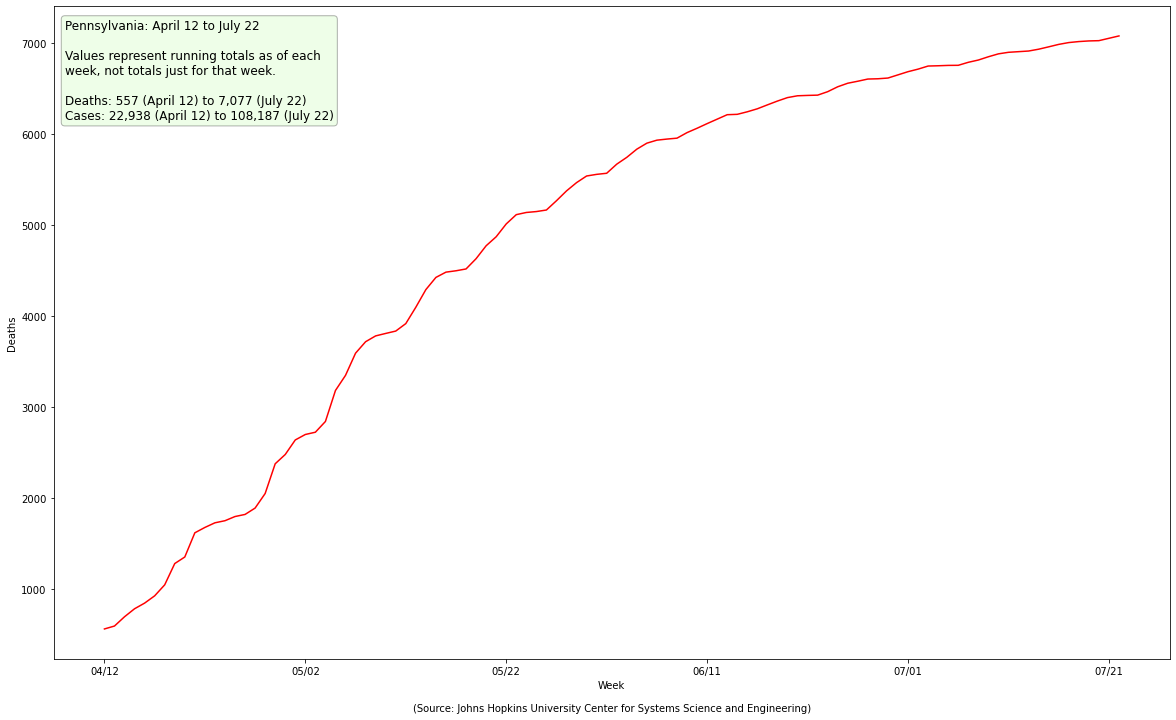

In [18]:
df_pa = df.loc[df.Province_State == 'Pennsylvania']
plot_stats_by_date(df_pa, textbox_heading="Pennsylvania", image_file="jhu-pa-deaths.png")

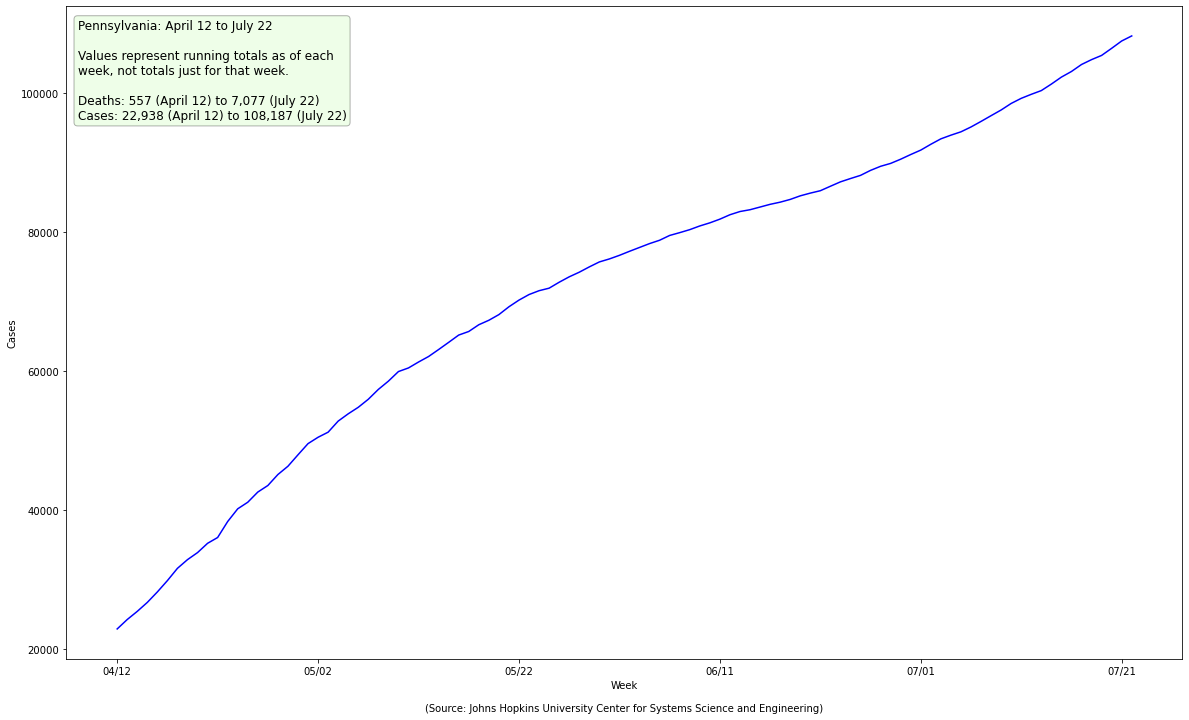

In [19]:
plot_stats_by_date(df_pa, textbox_heading="Pennsylvania", metrics={MetricType.CASES},
                   image_file="jhu-pa-cases.png")

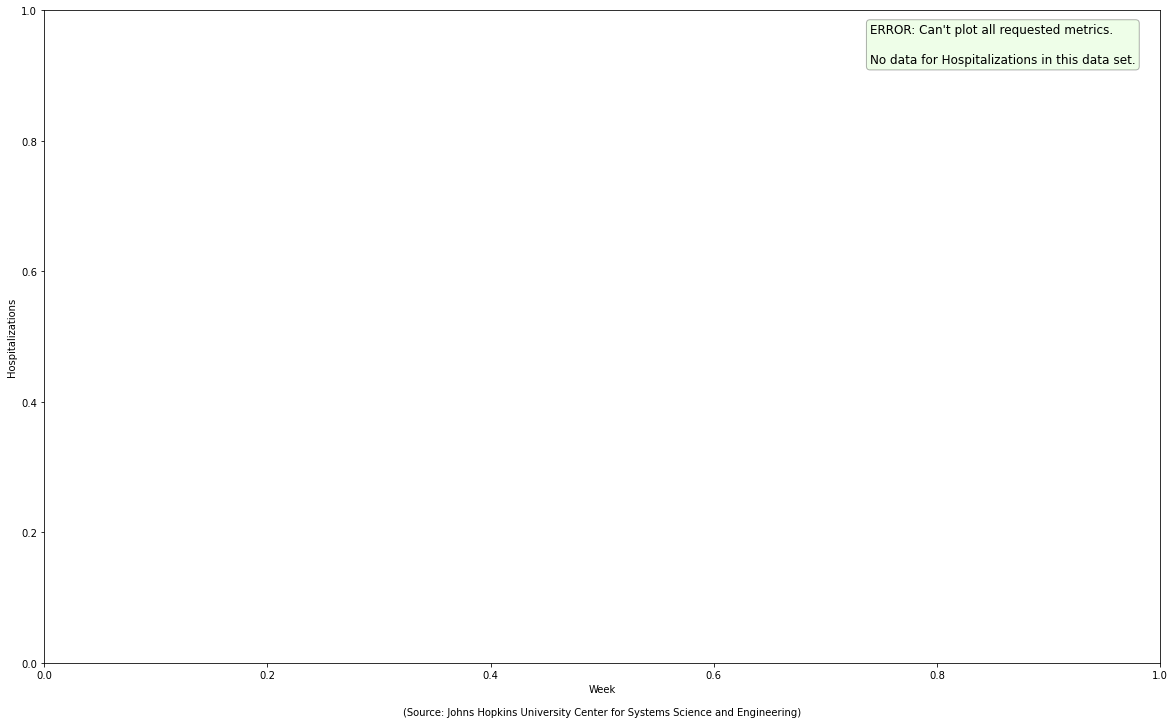

In [20]:
plot_stats_by_date(df_pa, metrics={MetricType.HOSPITALIZATIONS}, textbox_heading="Pennsylvania",
                   textbox_loc=(0.74, 0.98), image_file="jhu-pa-hosp.png")

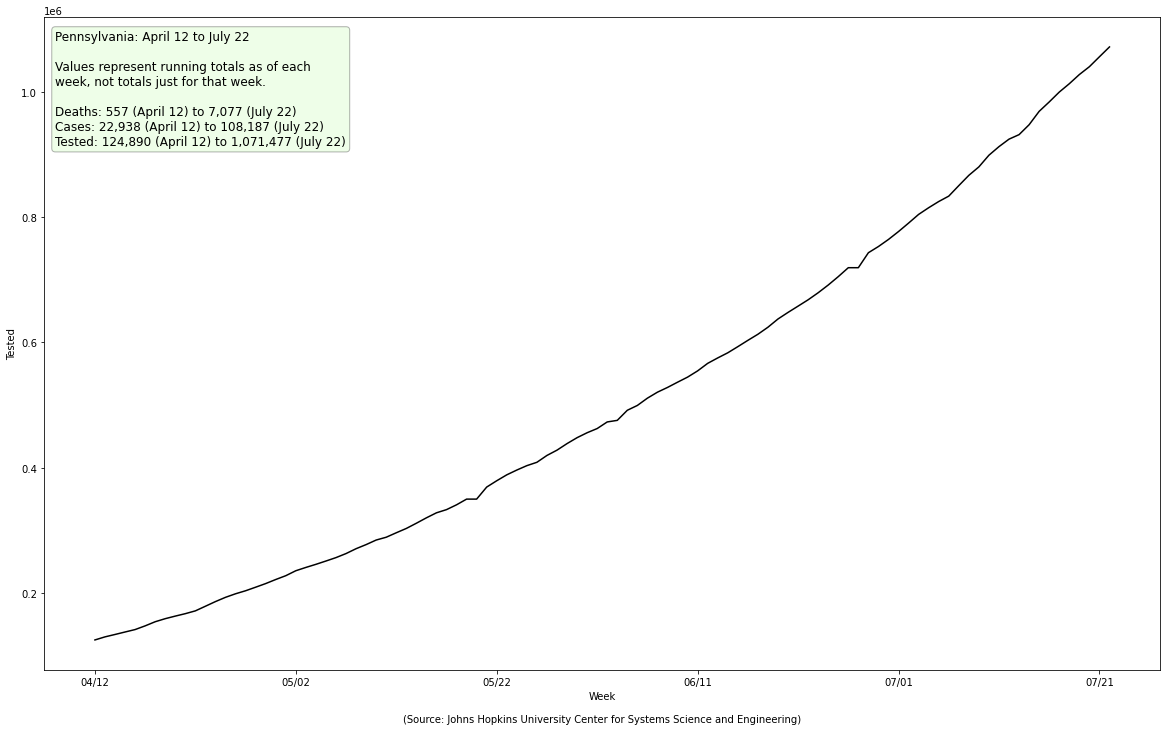

In [21]:
plot_stats_by_date(df_pa, metrics={MetricType.TESTED}, textbox_heading="Pennsylvania",
                   image_file="jhu-pa-tested.png")

### New York

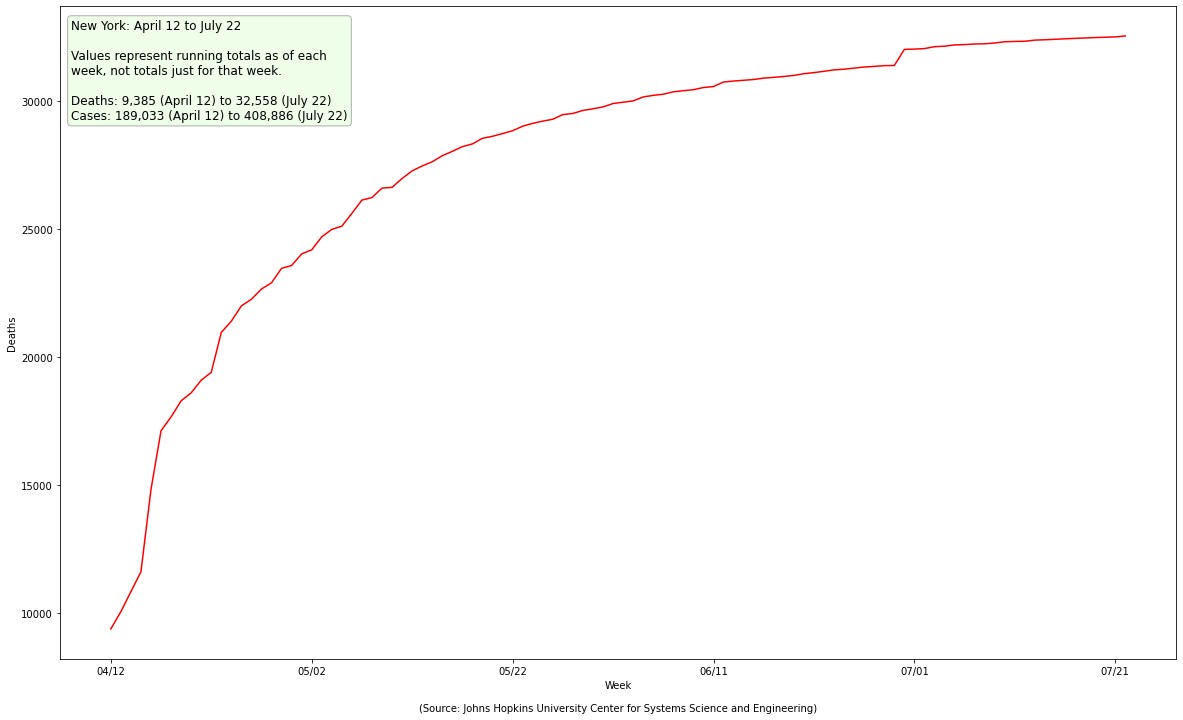

In [22]:
df_ny = df.loc[df.Province_State == 'New York']
plot_stats_by_date(df_ny, textbox_heading="New York", image_file="jhu-ny-deaths.png")

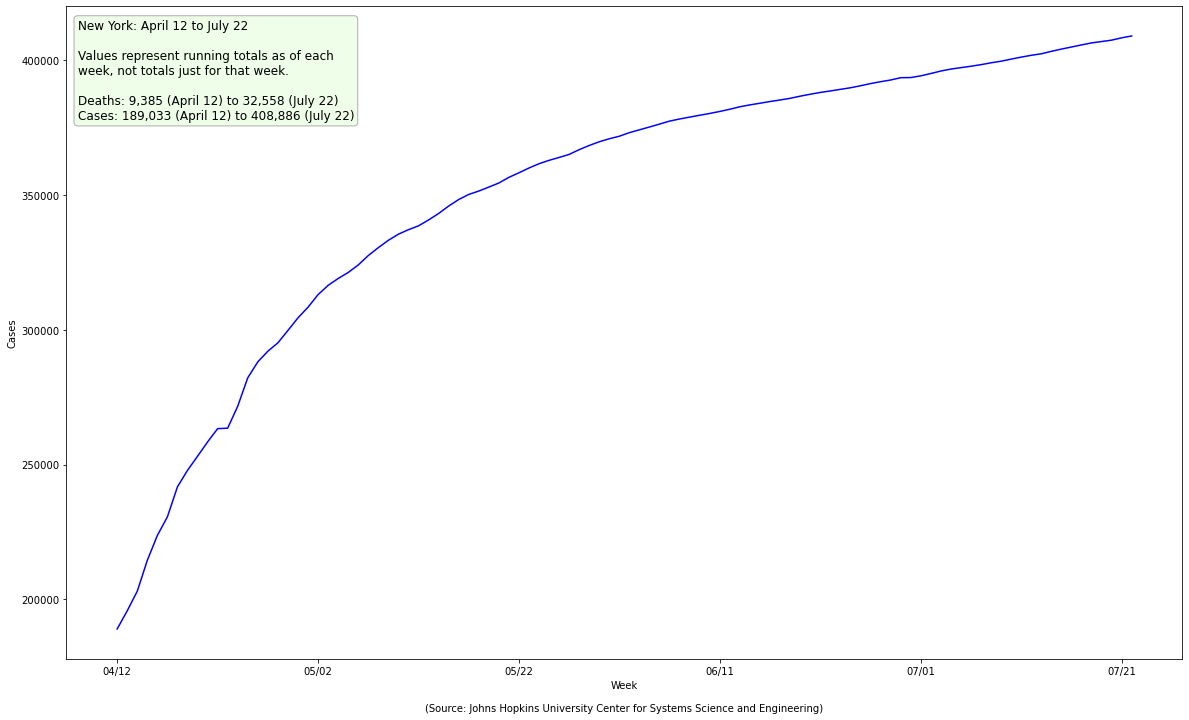

In [23]:
plot_stats_by_date(df_ny, textbox_heading="New York", metrics={MetricType.CASES}, image_file="jhu-ny-cases.png")

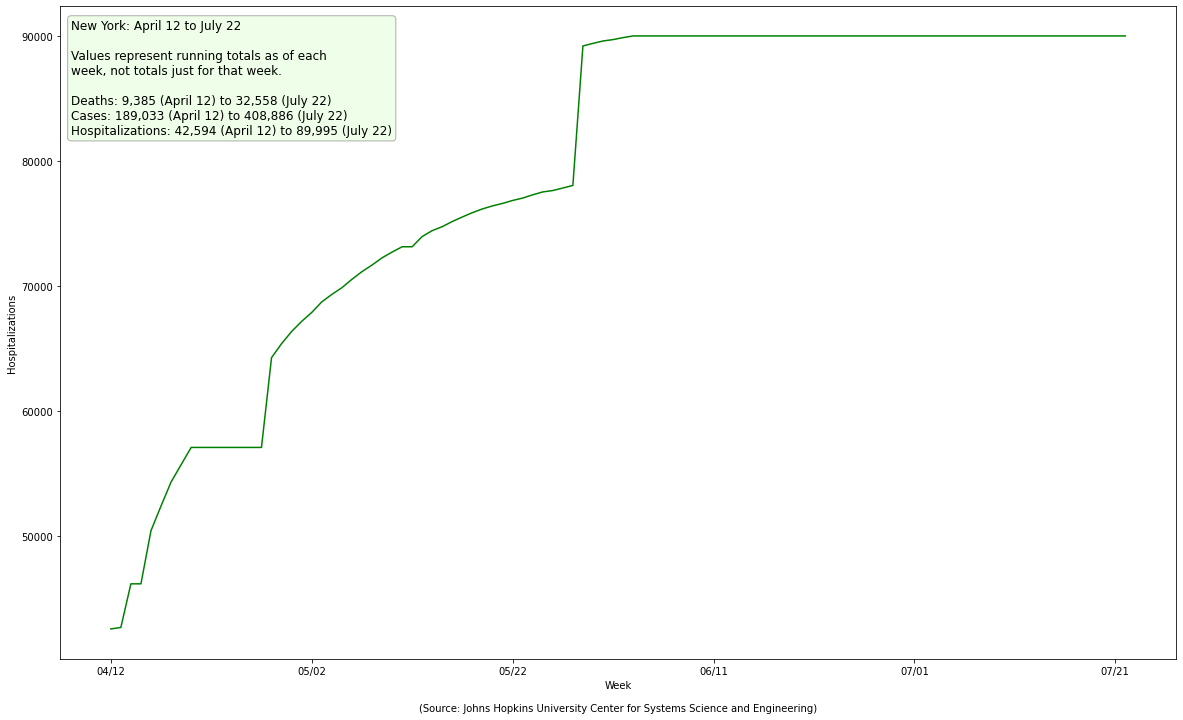

In [24]:
plot_stats_by_date(df_ny, textbox_heading="New York", metrics={MetricType.HOSPITALIZATIONS}, image_file="jhu-ny-hosp.png")

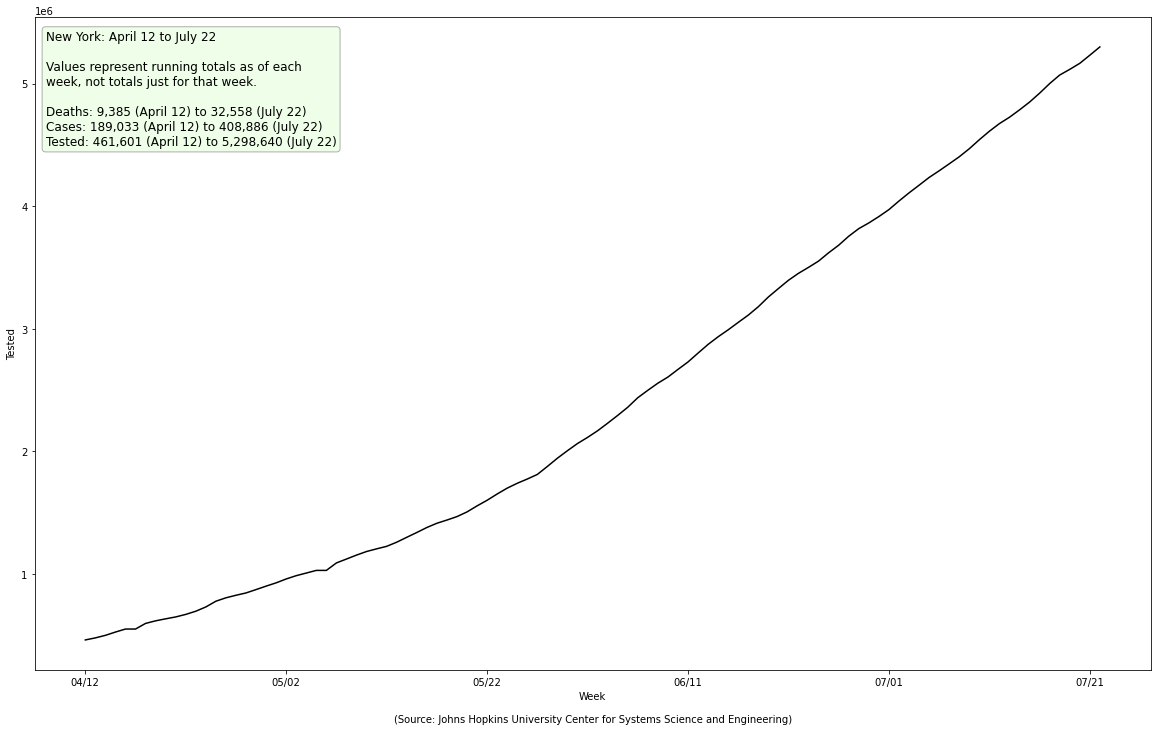

In [25]:
plot_stats_by_date(df_ny, textbox_heading="New York", metrics={MetricType.TESTED}, image_file="jhu-ny-tests.png")

### Washington

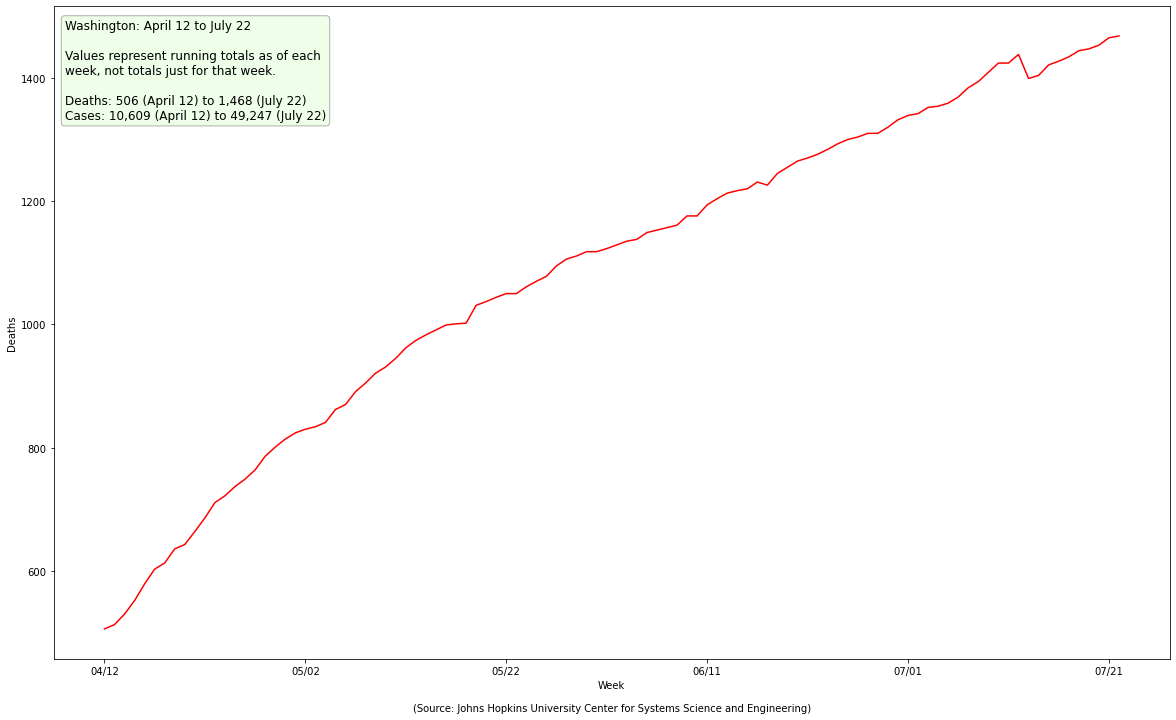

In [26]:
df_wa = df.loc[df.Province_State == 'Washington']
plot_stats_by_date(df_wa, textbox_heading="Washington", image_file="jhu-wa-deaths.png")

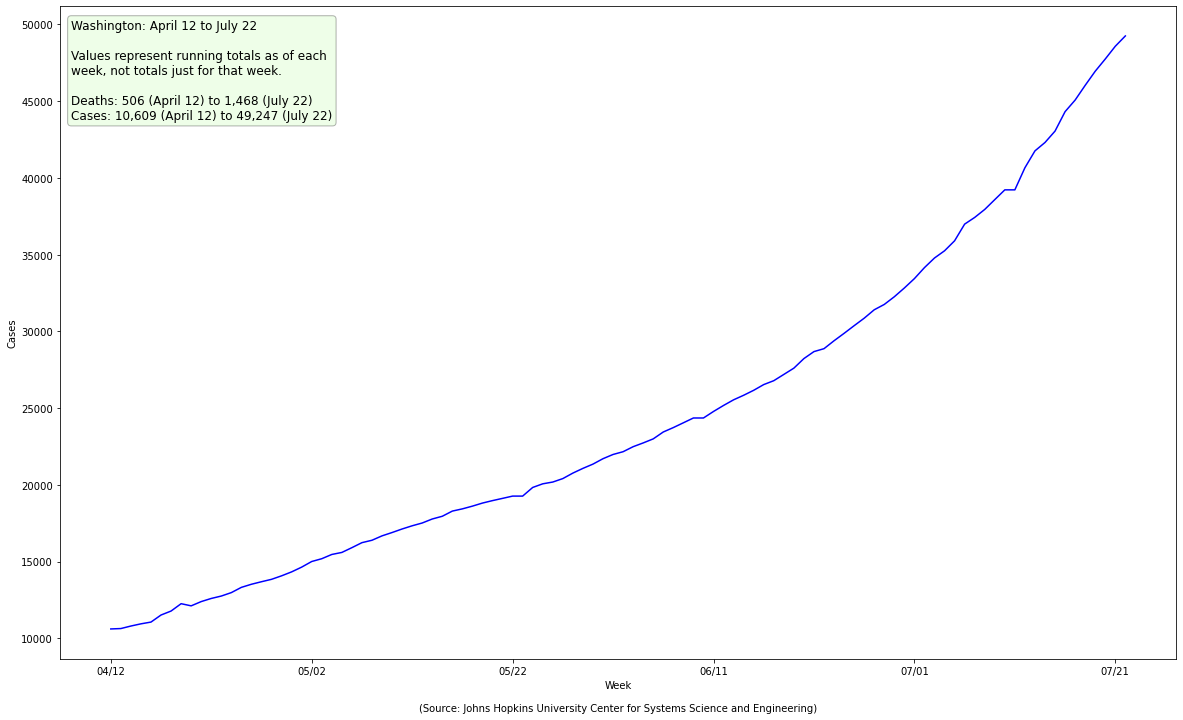

In [27]:
plot_stats_by_date(df_wa, textbox_heading="Washington", metrics={MetricType.CASES}, image_file="jhu-wa-cases.png")

### Delaware

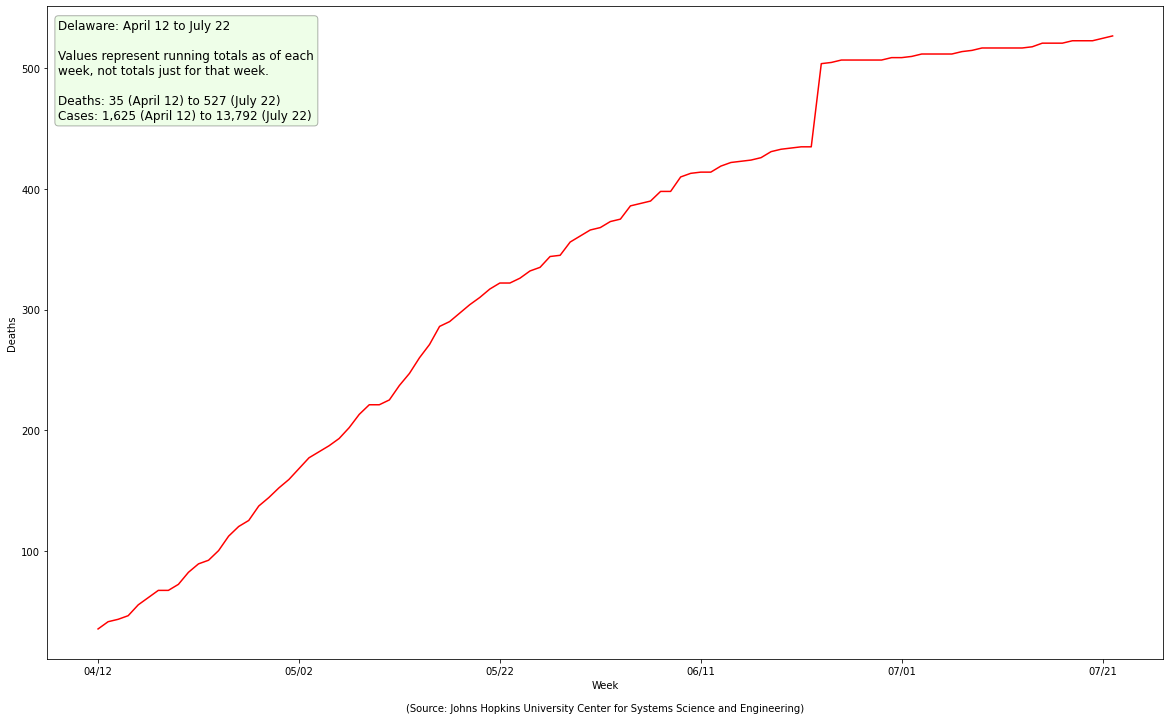

In [28]:
df_de = df.loc[df.Province_State == 'Delaware']
plot_stats_by_date(df_de, textbox_heading="Delaware", image_file="jhu-de-deaths.png")

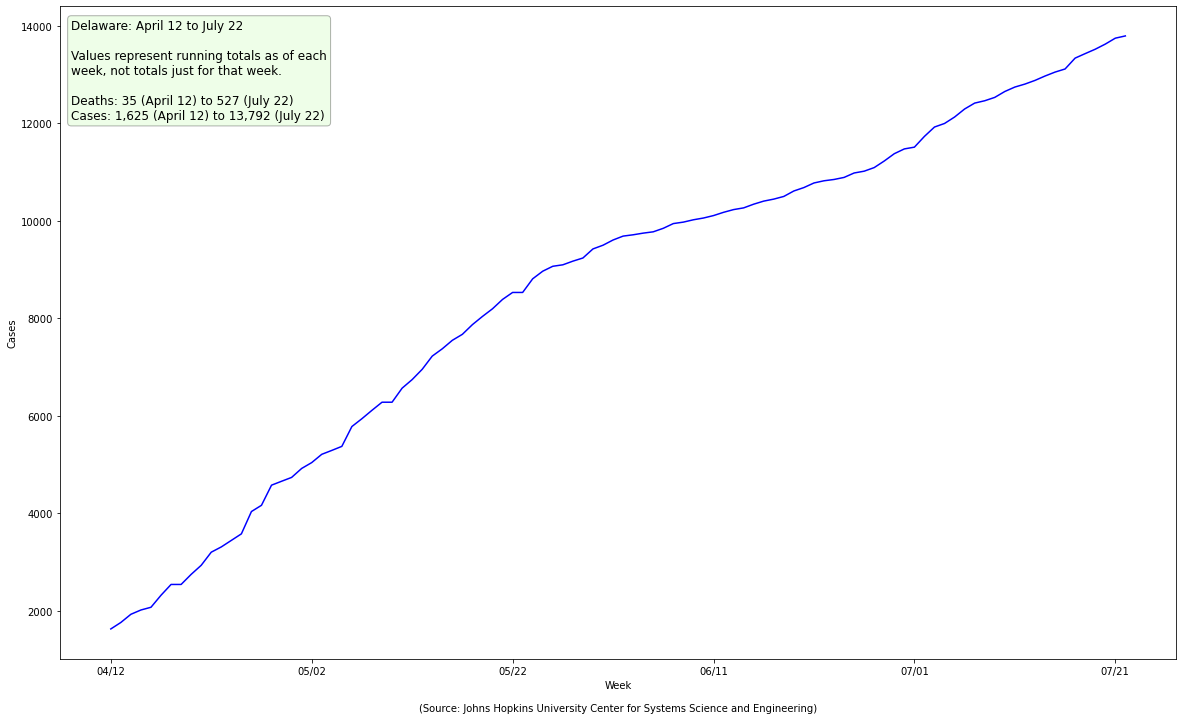

In [29]:
plot_stats_by_date(df_de, textbox_heading="Delaware", metrics={MetricType.CASES}, image_file="jhu-de-cases.png")

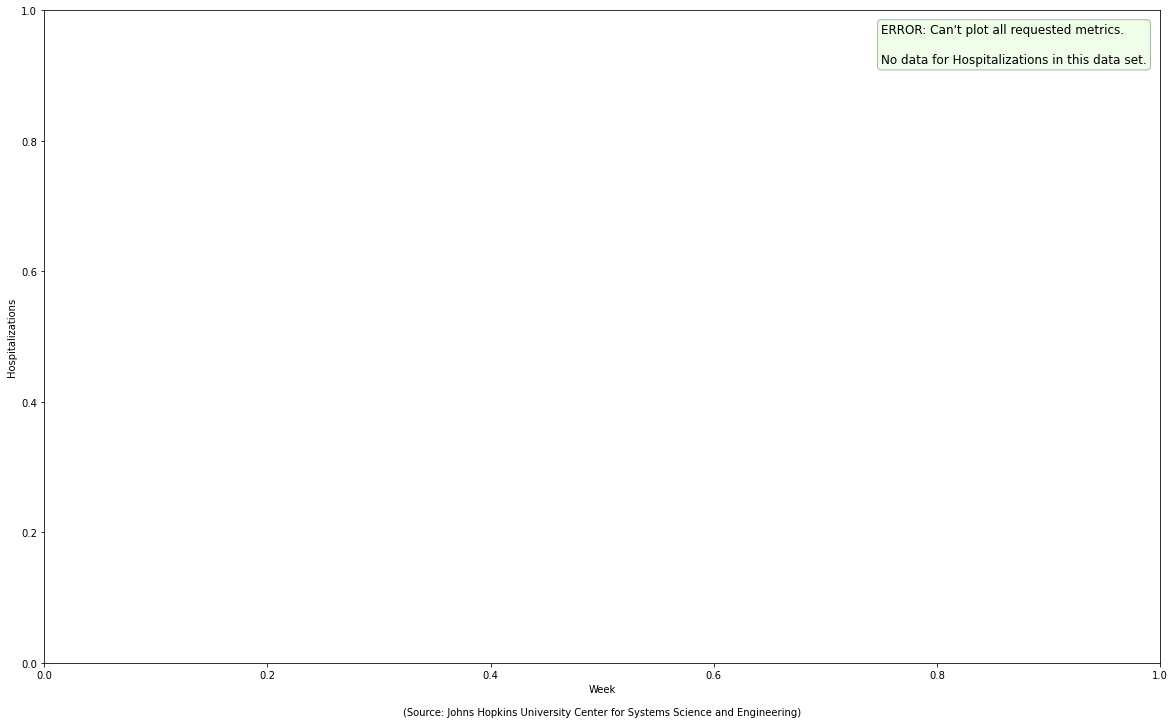

In [30]:
plot_stats_by_date(df_de, textbox_heading="Delaware", metrics={MetricType.HOSPITALIZATIONS}, 
                   textbox_loc=(0.75, 0.98), image_file="jhu-de-hosp.png")

### Texas

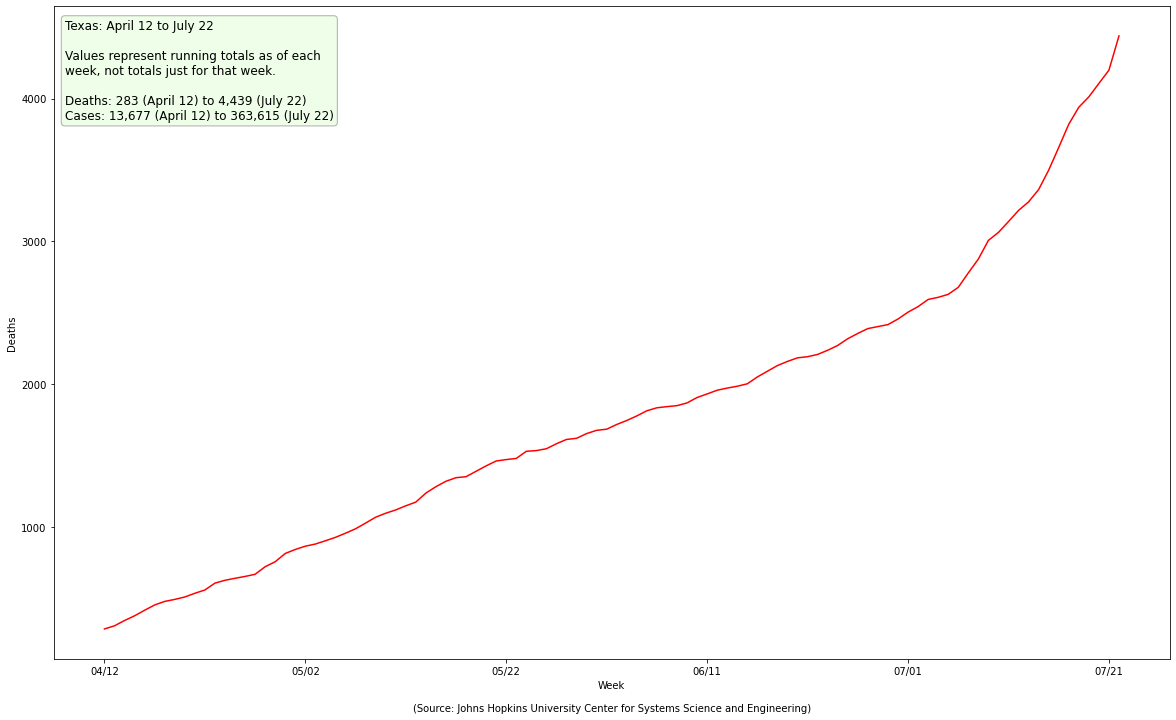

In [31]:
df_tx = df.loc[df.Province_State == 'Texas']
plot_stats_by_date(df_tx, textbox_heading="Texas", image_file="jhu-tx-deaths.png")

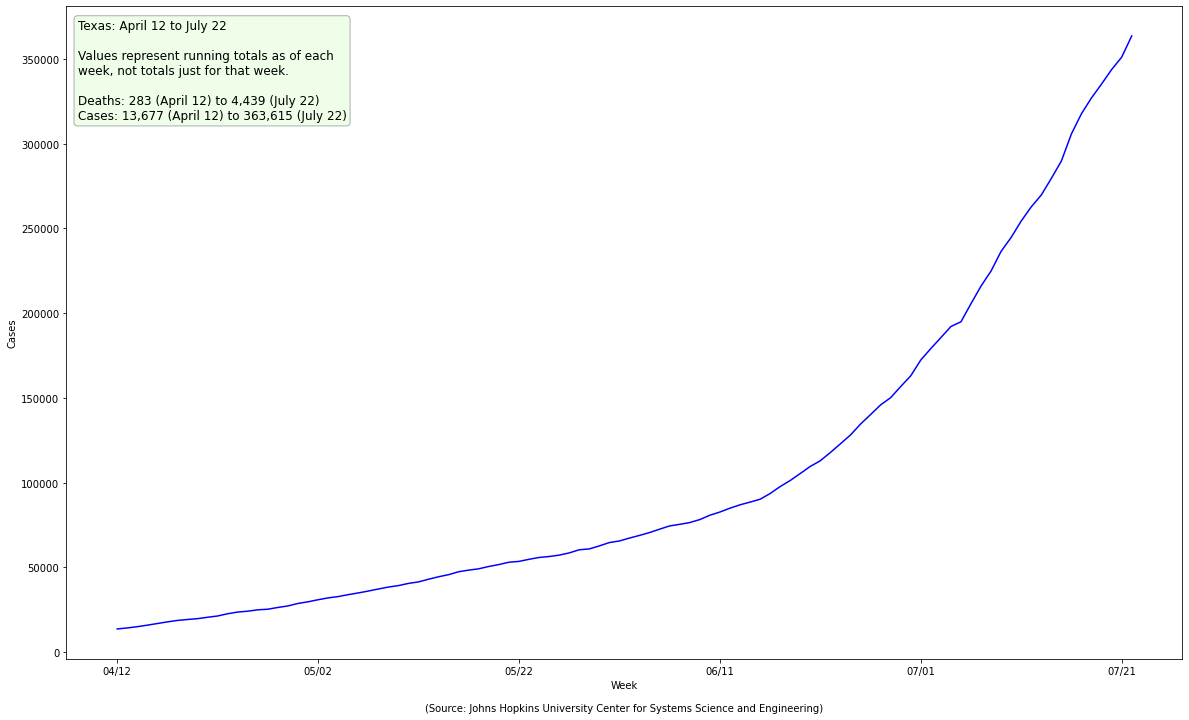

In [32]:
plot_stats_by_date(df_tx, textbox_heading="Texas", metrics={MetricType.CASES}, image_file="jhu-tx-cases.png")

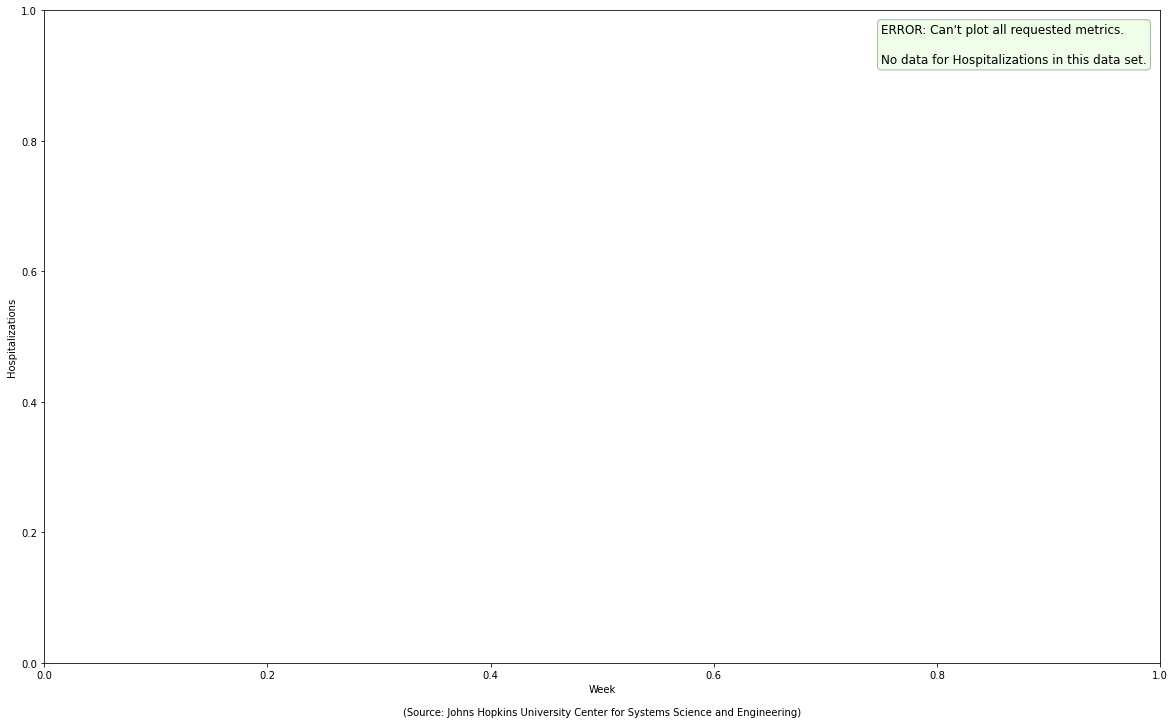

In [33]:
plot_stats_by_date(df_tx, textbox_heading="Texas", metrics={MetricType.HOSPITALIZATIONS}, 
                   textbox_loc=(0.75, 0.98), image_file="jhu-tx-hosp.png")

### Georgia

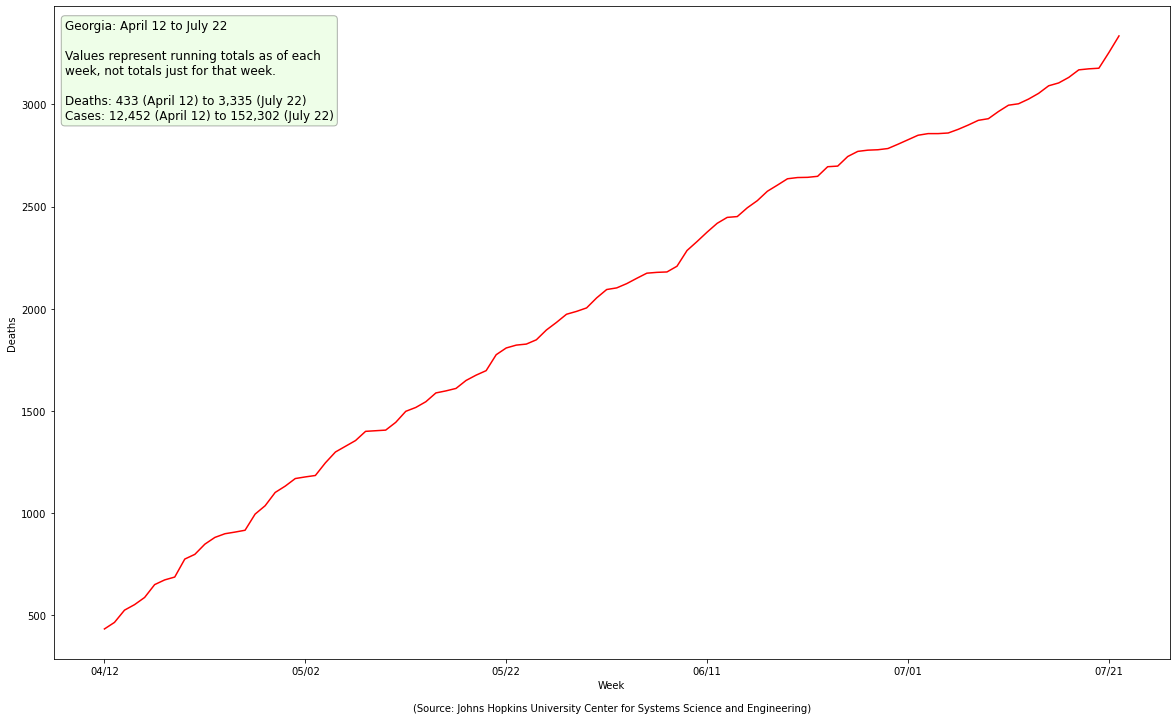

In [34]:
df_ga = df.loc[df.Province_State == 'Georgia']
plot_stats_by_date(df_ga, textbox_heading="Georgia", image_file="jhu-ga-deaths.png")

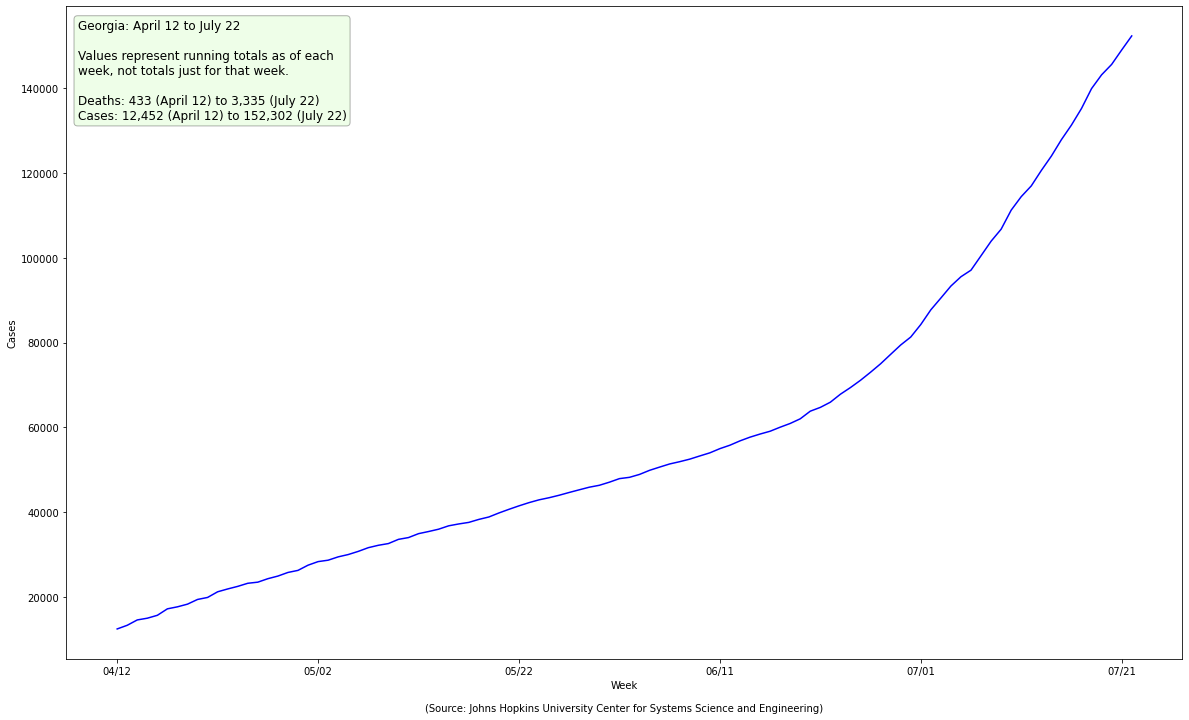

In [35]:
plot_stats_by_date(df_ga, textbox_heading="Georgia", metrics={MetricType.CASES}, image_file="jhu-ga-cases.png")

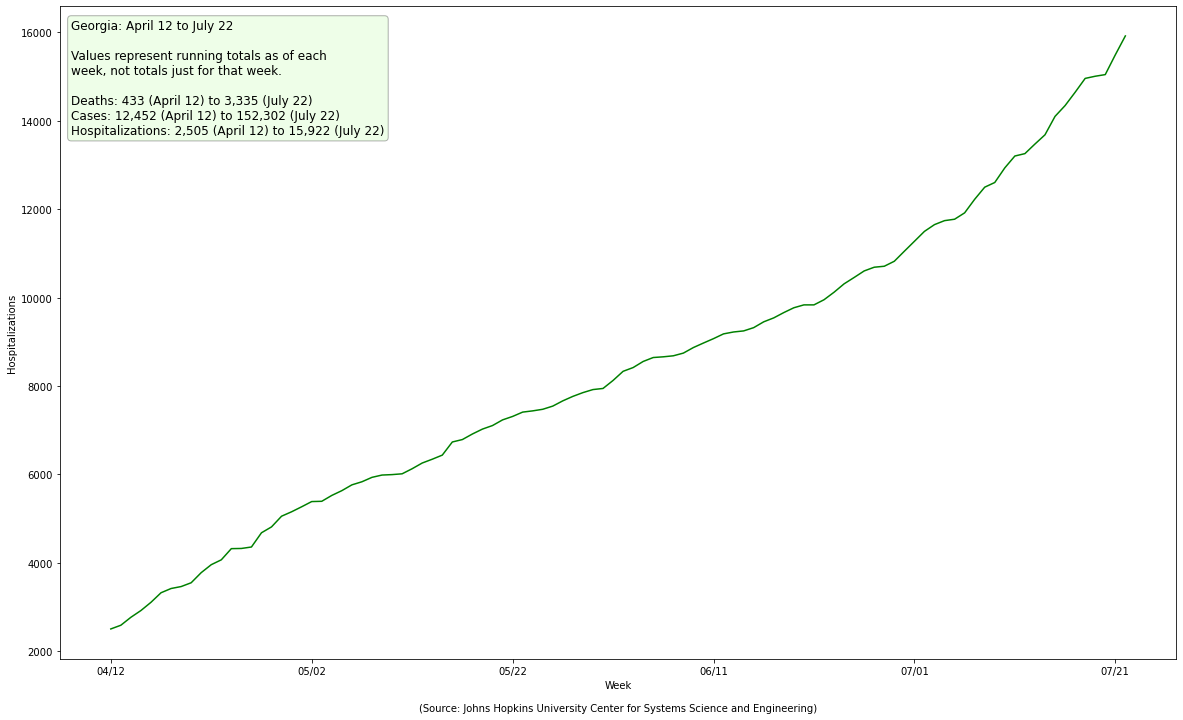

In [36]:
plot_stats_by_date(df_ga, textbox_heading="Georgia", metrics={MetricType.HOSPITALIZATIONS}, image_file="jhu-ga-hosp.png")

### Mississippi

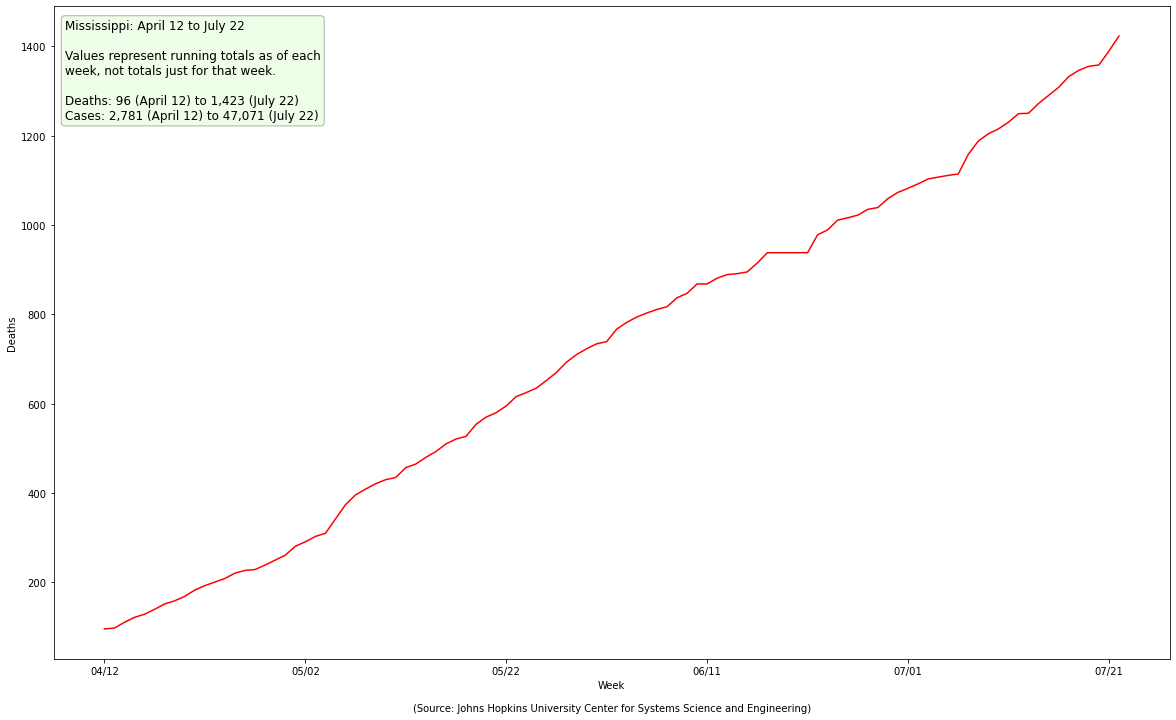

In [37]:
df_ms = df.loc[df.Province_State == 'Mississippi']
plot_stats_by_date(df_ms, textbox_heading="Mississippi", image_file="jhu-ms-deaths.png")

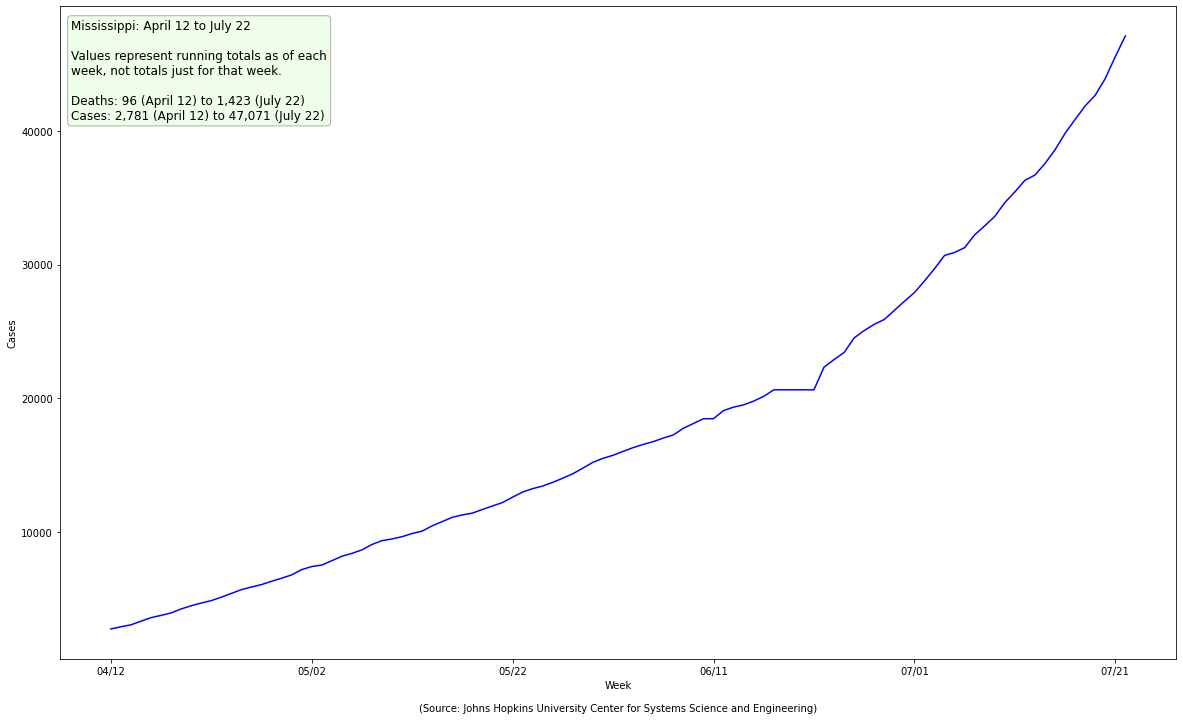

In [38]:
plot_stats_by_date(df_ms, textbox_heading="Mississippi", metrics={MetricType.CASES}, image_file="jhu-ms-cases.png")

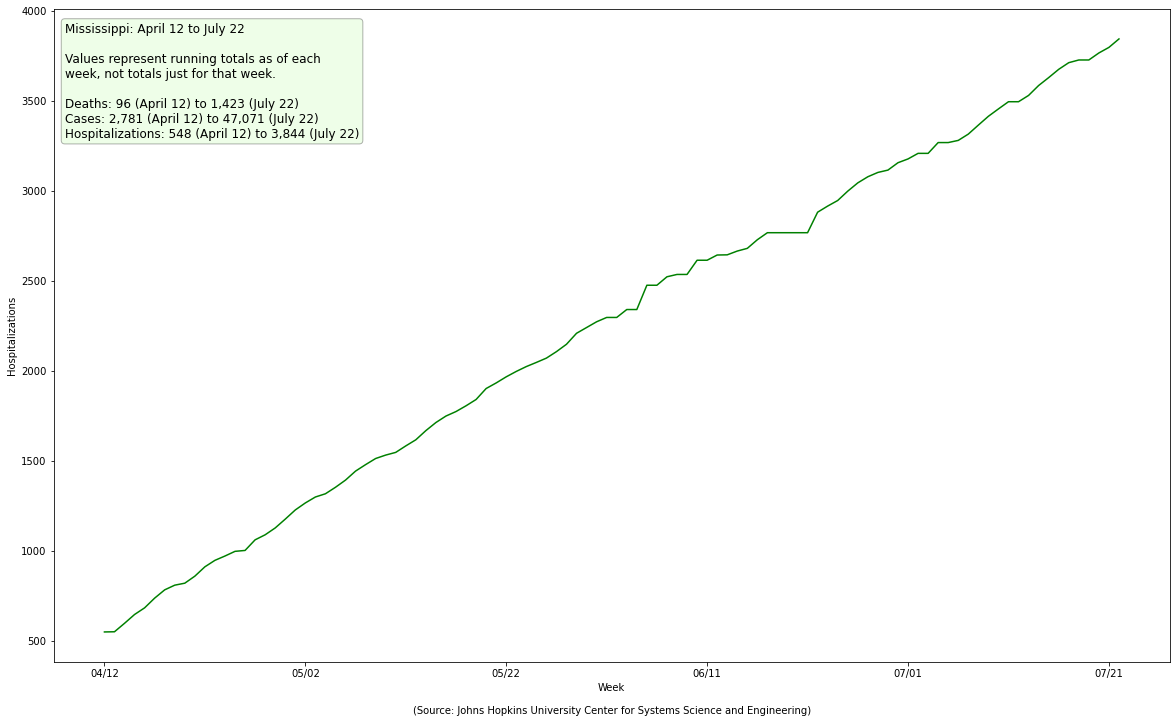

In [39]:
plot_stats_by_date(df_ms, textbox_heading="Mississippi", metrics={MetricType.HOSPITALIZATIONS}, image_file="jhu-ms-hosp.png")

### Arizona

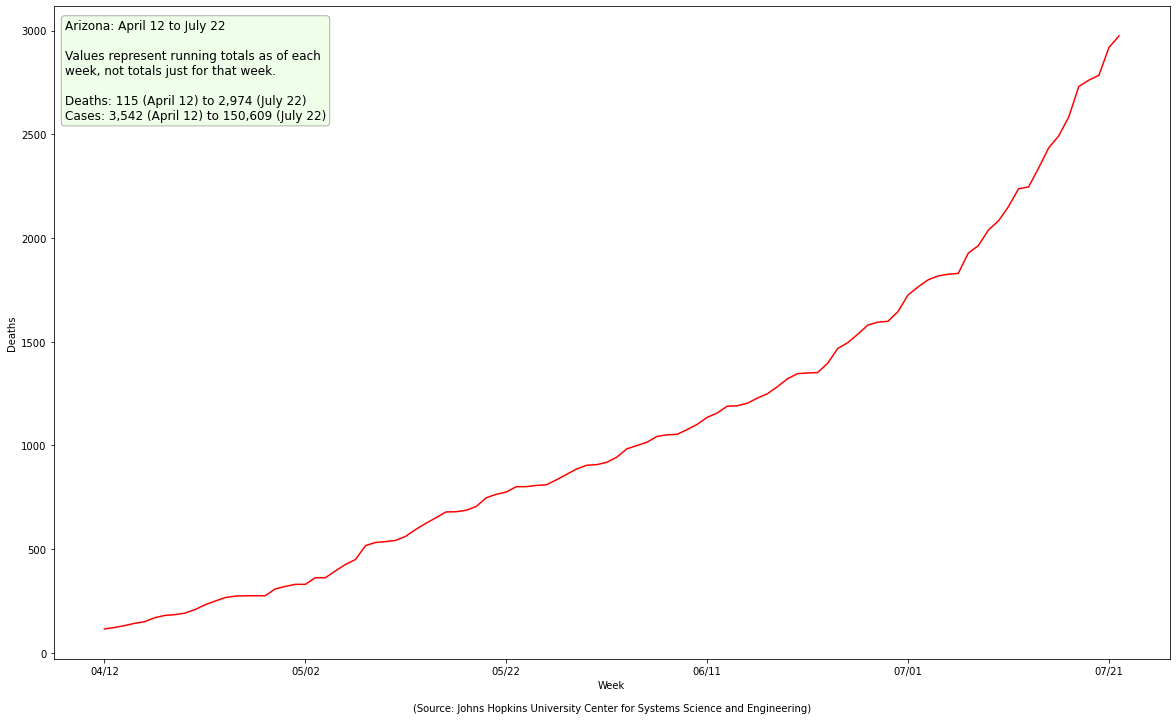

In [40]:
df_az = df.loc[df.Province_State == 'Arizona']
plot_stats_by_date(df_az, textbox_heading="Arizona", image_file="jhu-az-deaths.png")

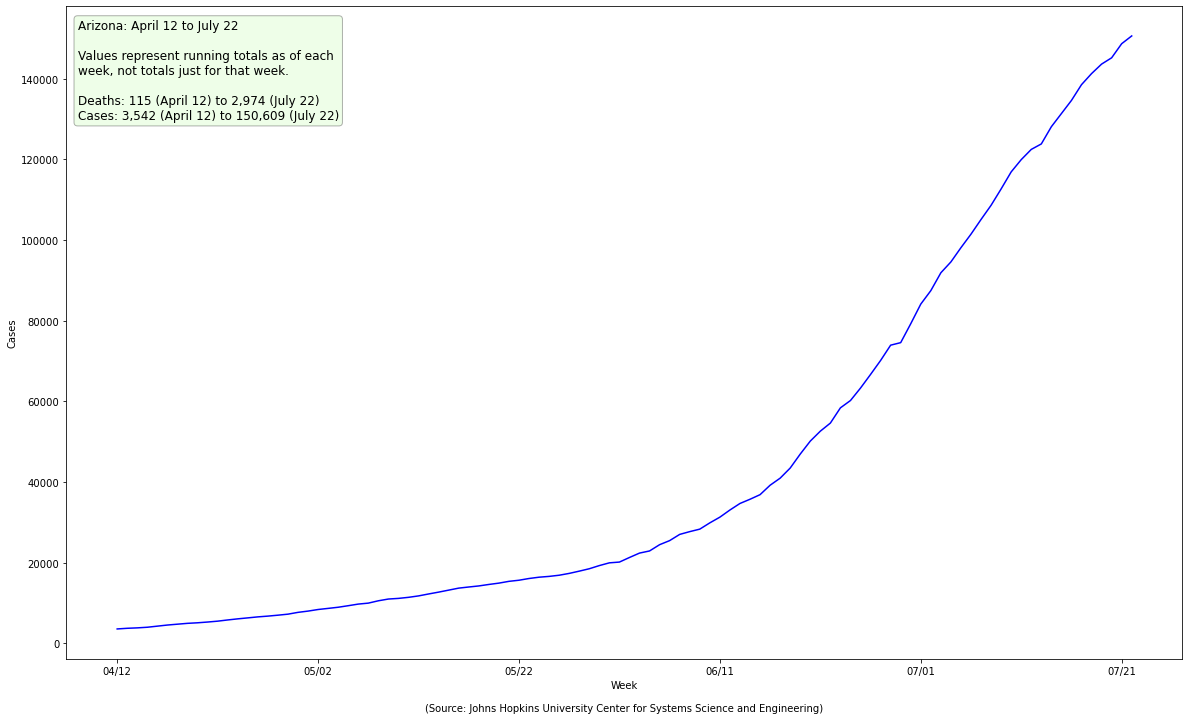

In [41]:
plot_stats_by_date(df_az, textbox_heading="Arizona", metrics={MetricType.CASES}, image_file="jhu-az-cases.png")

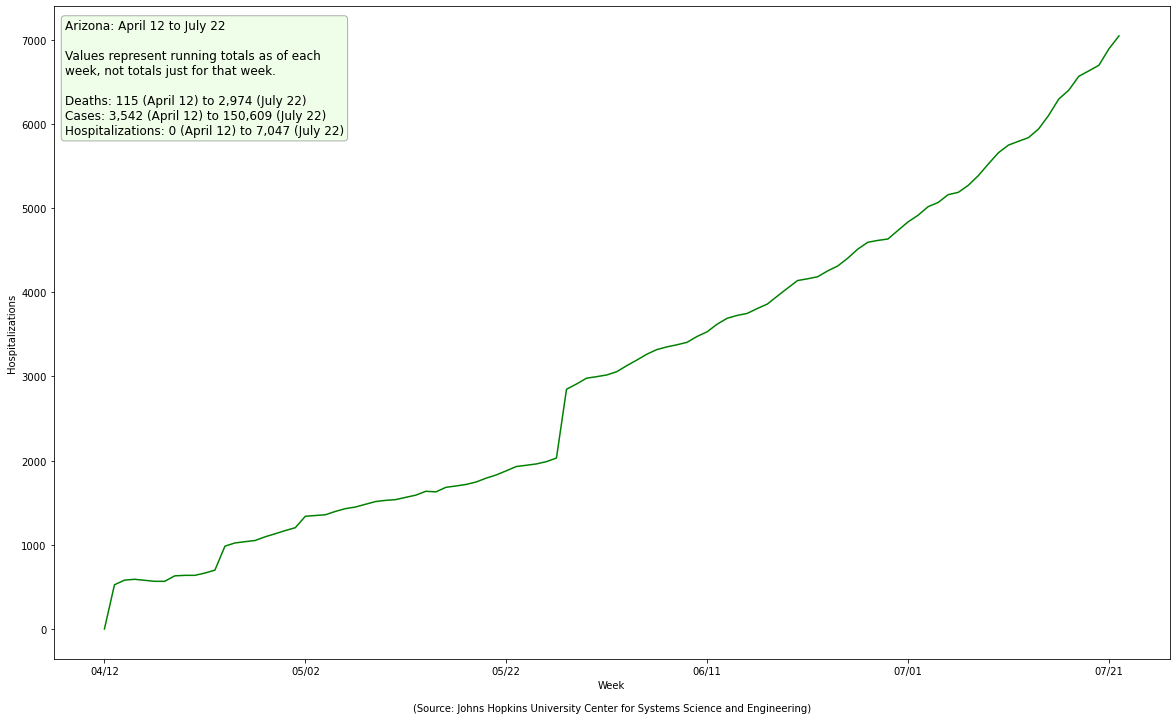

In [42]:
plot_stats_by_date(df_az, textbox_heading="Arizona", metrics={MetricType.HOSPITALIZATIONS}, image_file="jhu-az-hosp.png")

### Florida

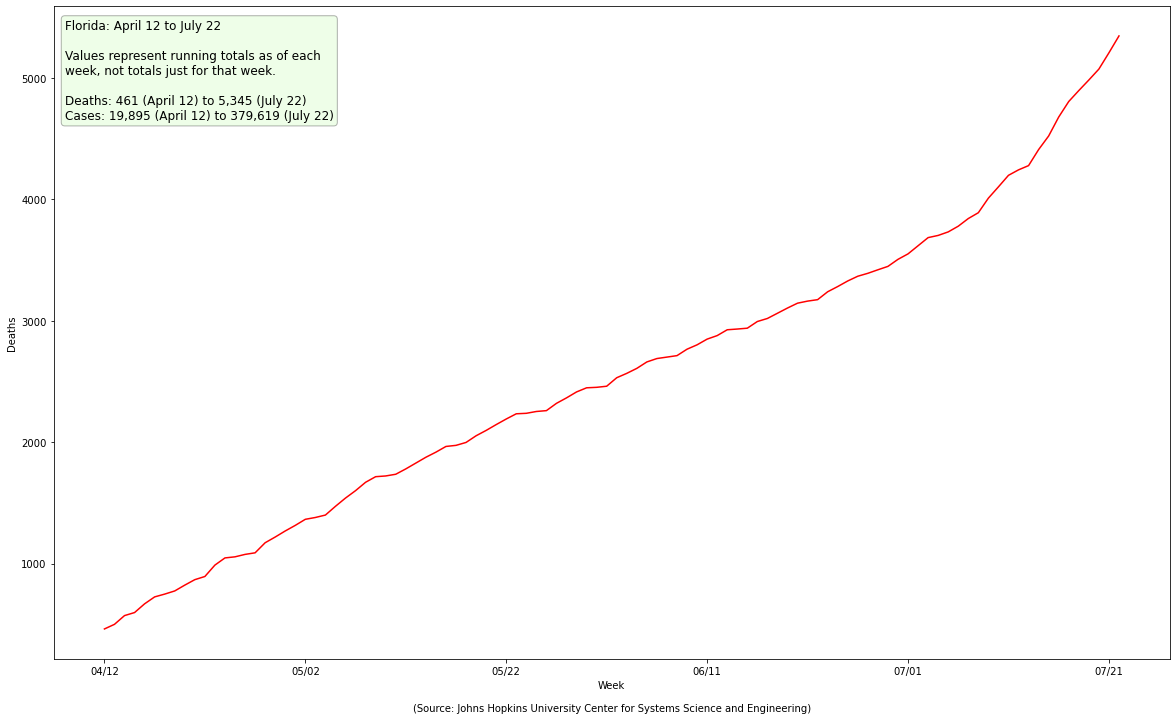

In [43]:
df_fl = df.loc[df.Province_State == 'Florida']
plot_stats_by_date(df_fl, textbox_heading="Florida", image_file="jhu-fl-deaths.png")

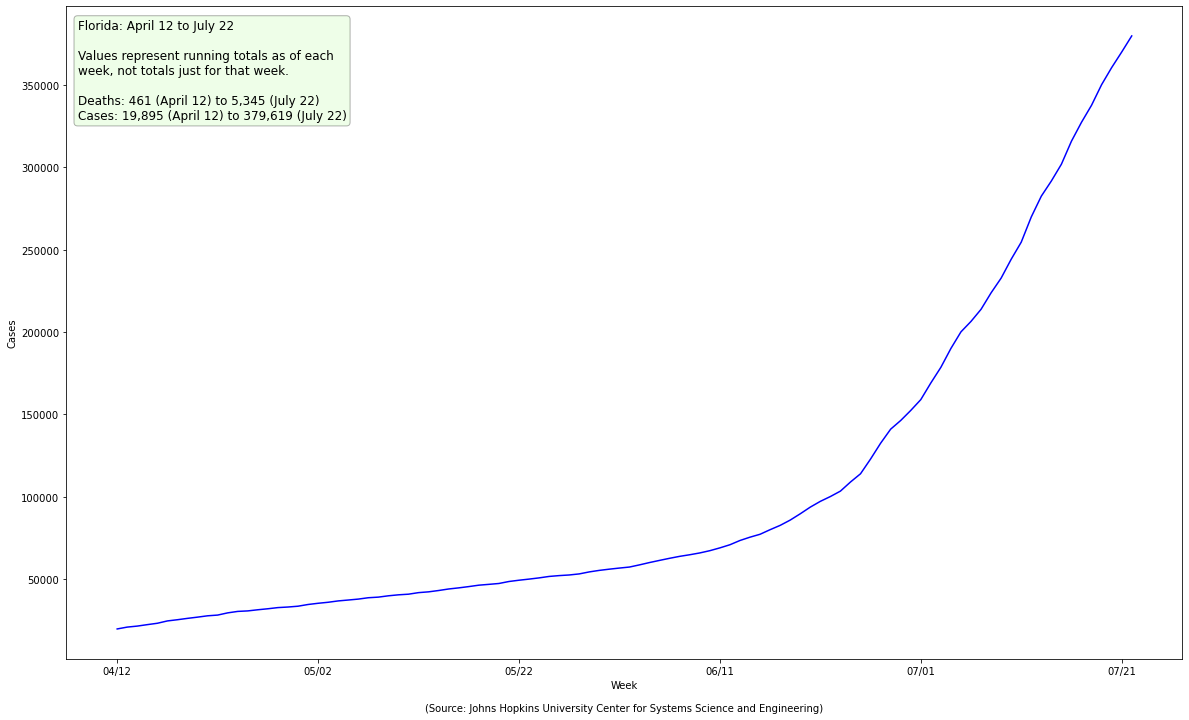

In [44]:
plot_stats_by_date(df_fl, textbox_heading="Florida", image_file="jhu-fl-deaths.png", metrics={MetricType.CASES})

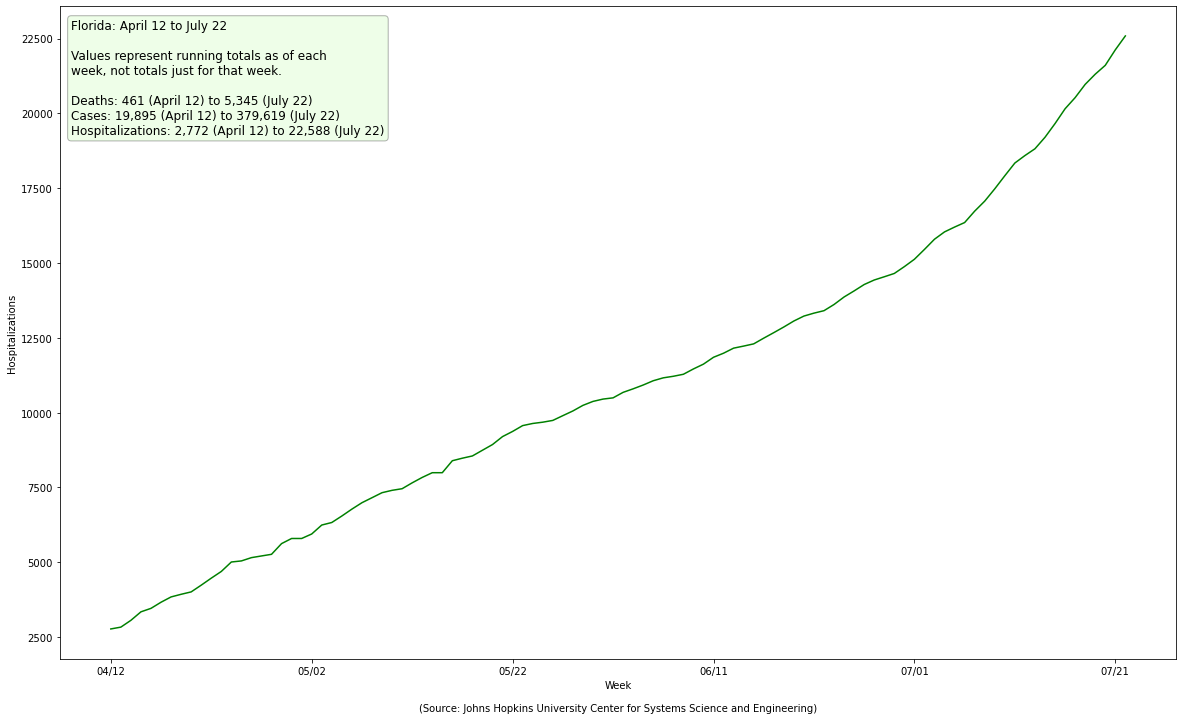

In [45]:
plot_stats_by_date(df_fl, textbox_heading="Florida", image_file="jhu-fl-hosp.png", metrics={MetricType.HOSPITALIZATIONS})

### South Carolina

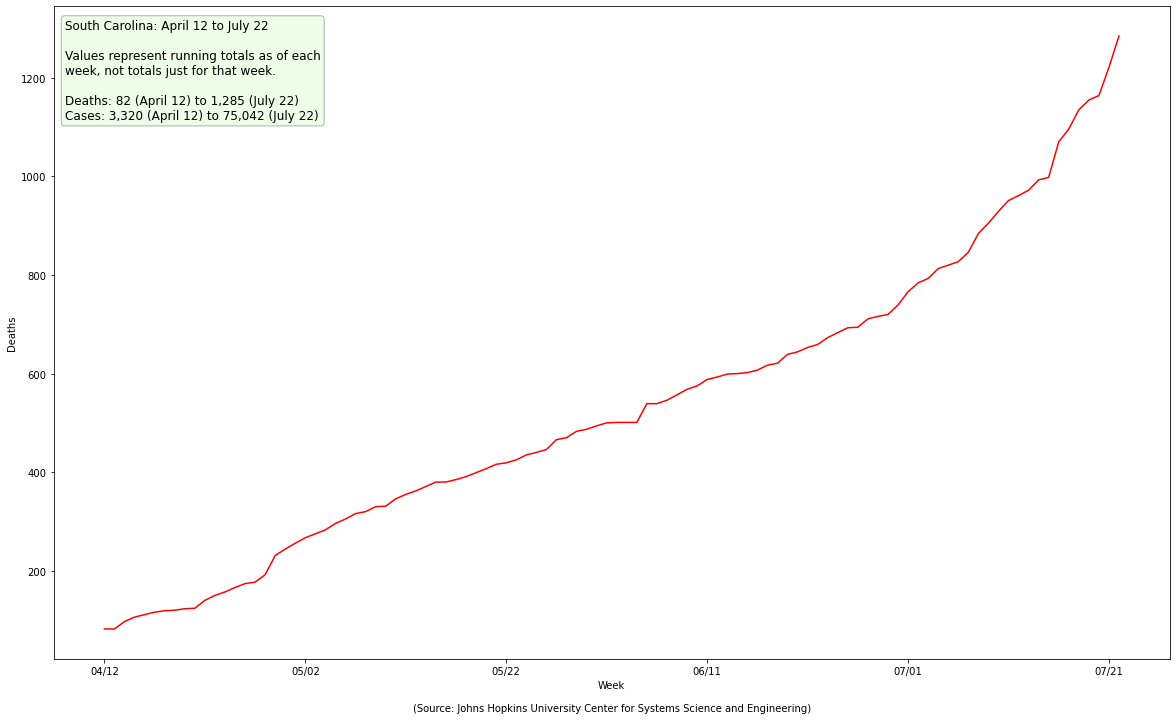

In [46]:
df_sc = df.loc[df.Province_State == 'South Carolina']
plot_stats_by_date(df_sc, textbox_heading="South Carolina", image_file="jhu-sc-deaths.png")

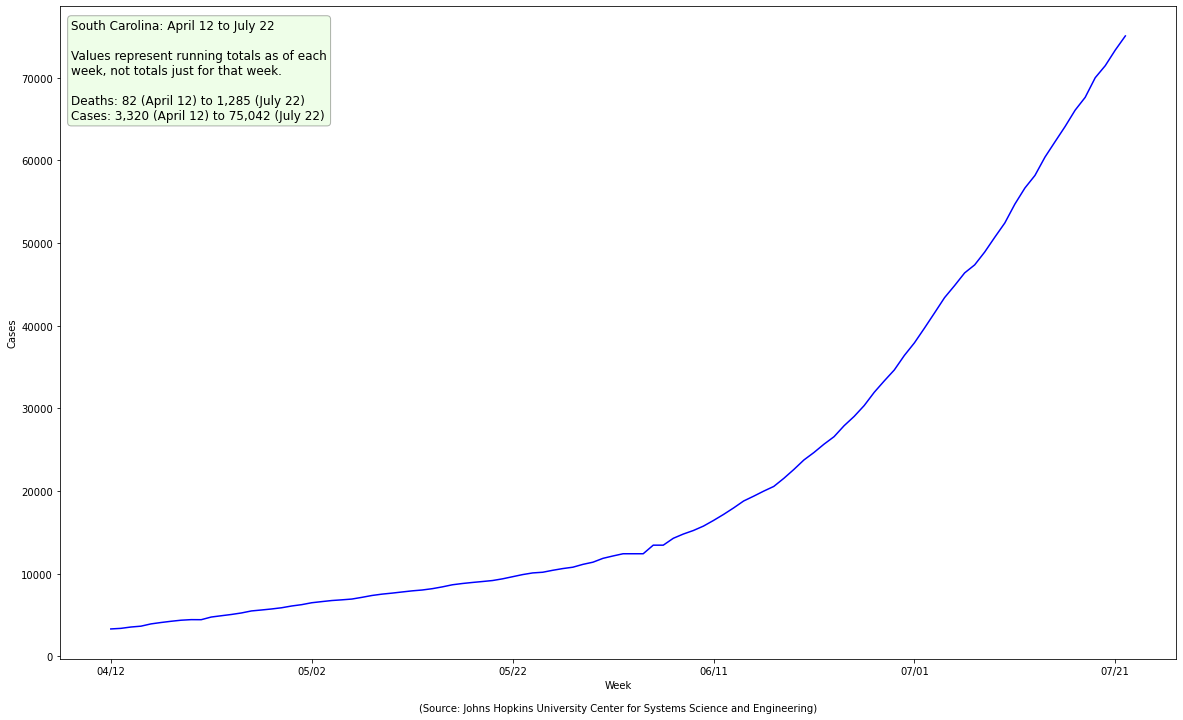

In [47]:
plot_stats_by_date(df_sc, textbox_heading="South Carolina", image_file="jhu-sc-deaths.png", metrics={MetricType.CASES})

### Oklahoma

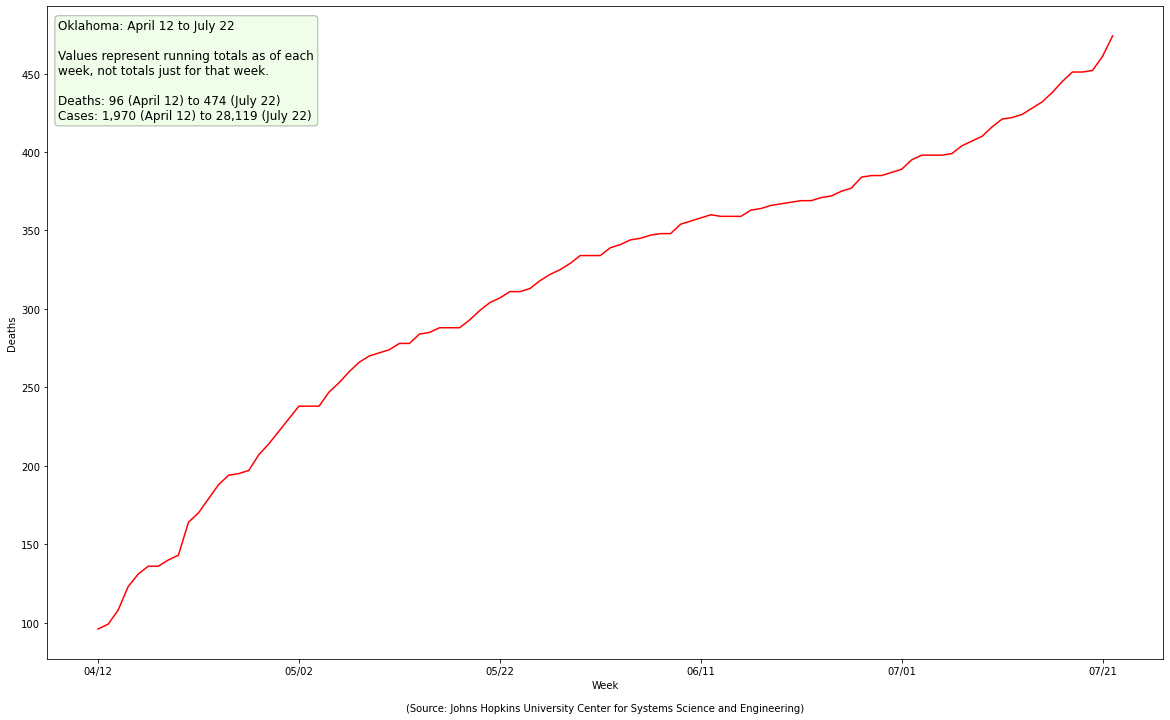

In [48]:
df_ok = df.loc[df.Province_State == 'Oklahoma']
plot_stats_by_date(df_ok, textbox_heading="Oklahoma", image_file="jhu-ok-deaths.png")

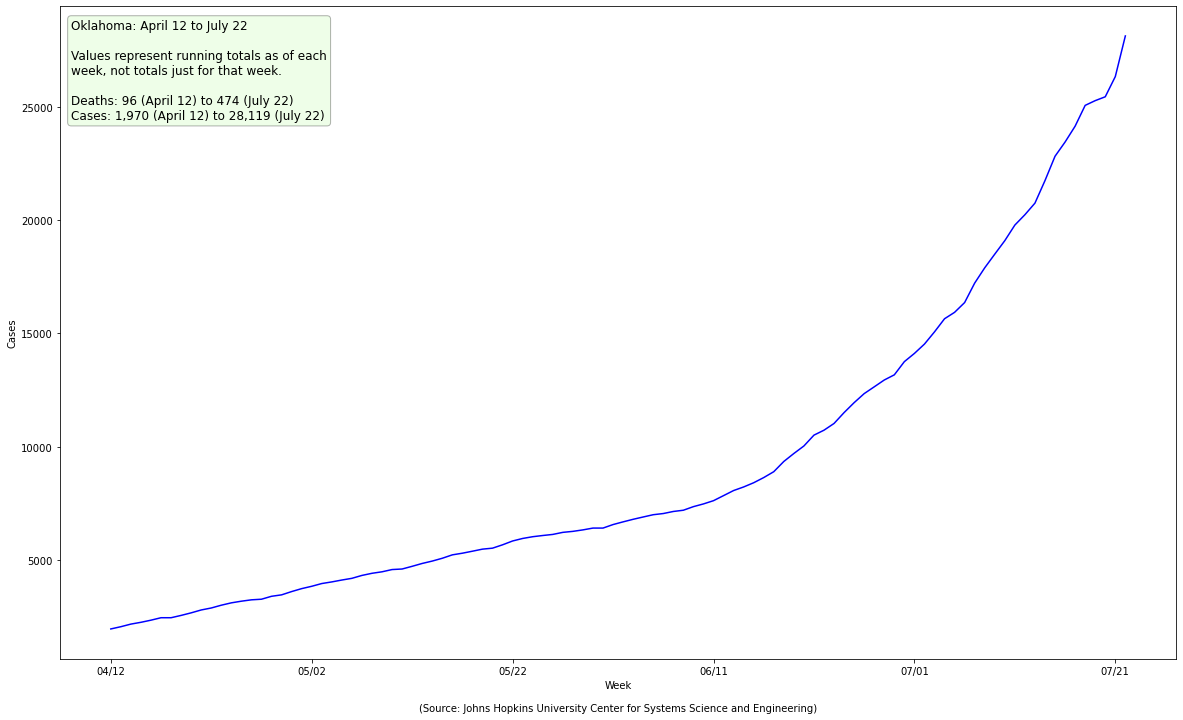

In [49]:
plot_stats_by_date(df_ok, textbox_heading="Oklahoma", image_file="jhu-ok-deaths.png", metrics={MetricType.CASES})

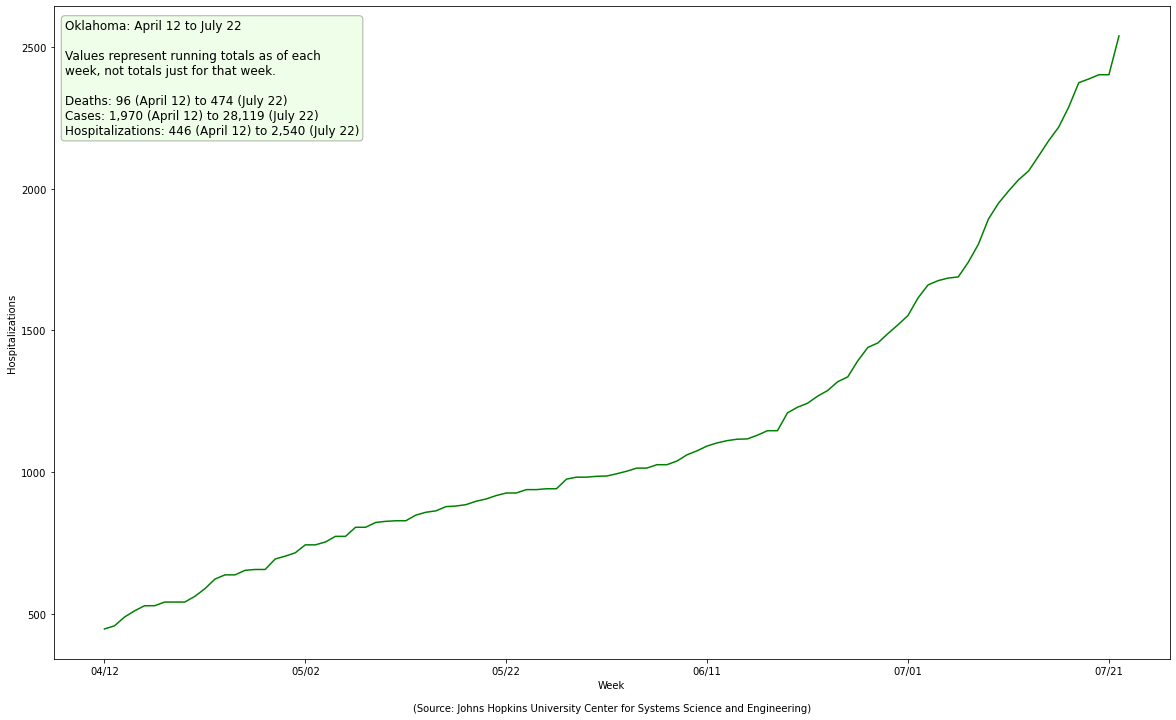

In [50]:
plot_stats_by_date(df_ok, textbox_heading="Oklahoma", image_file="jhu-ok-hosp.png", metrics={MetricType.HOSPITALIZATIONS})

## Multistate

In [59]:
def plot_states(df, states, metric=MetricType.DEATHS, per_n=1,
                populations=None, textbox_heading=None, textbox_loc=None, 
                figsize=(20, 12), legend_loc="lower right", image_file=None):
    """
    Takes a Pandas DataFrame with the Johns Hopkins data, and plots a particular
    metric once for each of a group of states, across all the dates in the
    DataFrame.
    
    Parameters:
    
    df              - The Pandas DataFrame from which to select the data.
    states          - The names of the states.
    metric          - The metric to plot. Defaults to deaths.
    per_n           - If set to 1, plot the data as is. Otherwise, do a per-capita
                      plot (i.e., number of X per n people). If per_n is not 1,
                      then population must be defined.
    populations     - The dictionary of populations per state. Only necessary
                      if per_n is greater than 1.
    figsize         - The size of the plot.
    textbox_heading - An optional heading to add to the textbox annotation
    textbox_loc     - An (x, y) tuple for the location of the text box's top
                      left corner. Defaults to the upper left.
    legend_loc      - Location of the legend, using matplotlib semantics. Defaults
                      to "lower right"
    image_file      - Name of image file in which to save plot, or None.
    """
    def fix_legend(ax):
        # The generated labels look like "(Confirmed, Connecticut)" 
        # or "(Deaths, Connecticut)". Adjust the legend to get rid 
        # of the parentheses and the metric name, leaving only the state.
        patches, labels = ax.get_legend_handles_labels()
        pat = re.compile(r'^\([^,\s]+,\s+(.*)\)$')
        labels2 = []
        for label in labels:
            m = pat.match(label)
            assert m is not None
            labels2.append(m.group(1))
        ax.legend(patches, labels2, loc=legend_loc)

    # Get a derived DataFrame with just the states passed in.
    # Also, we only care about the Province_State, Month_Day
    # and particular statistic column. Finally, ensure that the
    # resulting DataFrame is sorted by date, just in case the 
    # original was reordered.
    metric_col = METRIC_COLUMNS[metric]
    df2 = (df.loc[df.Province_State.isin(states)][['Province_State', 'Month_Day', metric_col]]
             .sort_values(by=['Month_Day'], inplace=False))
    if per_n > 1:
        func = lambda r: get_per_capita_float(r[metric_col], populations[r.Province_State])
        df2[metric_col] = df2.apply(func, axis=1)

    # GROUP BY, SUM. Hello, SQL folks...
    group = df2.groupby(['Month_Day', 'Province_State']).sum()
    
    # Unstack, to get each state's numbers in a separate column.
    final_df = group.unstack()

    fig, ax = p.subplots(figsize=figsize)

    # Let Pandas plot the whole thing.
    final_df.plot(ax=ax, kind='line', legend=True)
    fix_legend(ax)

    # Set the X and Y axis labels. Add the credit below the X label,
    # since it's a nice place to stash it without interfering with
    # the plot.
    xlabel = ("Week\n\n"
              "(Source: Johns Hopkins University Center for Systems Science and Engineering)")
    ax.set_xlabel(xlabel)
    metric_label = METRIC_LABELS[metric]
    label = metric_label if per_n == 1 else f"{metric_label} per {per_n:,} people"
    ax.set_ylabel(label)

    # Add an explanatory text box.
    text_x, text_y = textbox_loc or (0.01, 0.987)
    heading = "" if textbox_heading is None else f"{textbox_heading}: "
    text_lines = [f"{heading}{label}\n"]
    for state in sorted(states):
        # Get the last value for the metric. It's the grand totle.
        total = round(int(df2.loc[df2.Province_State == state][metric_col].iloc[-1]))
        text_lines.append(f"{state}: {total:,}")
    textbox(ax, text_x, text_y, '\n'.join(text_lines))


### Northeast states

Data from some of the states that were hardest hit early on.

In [60]:
ne_states = ('Connecticut', 'New York', 'New Jersey', 'Pennsylvania', 'Delaware', 'Ohio')

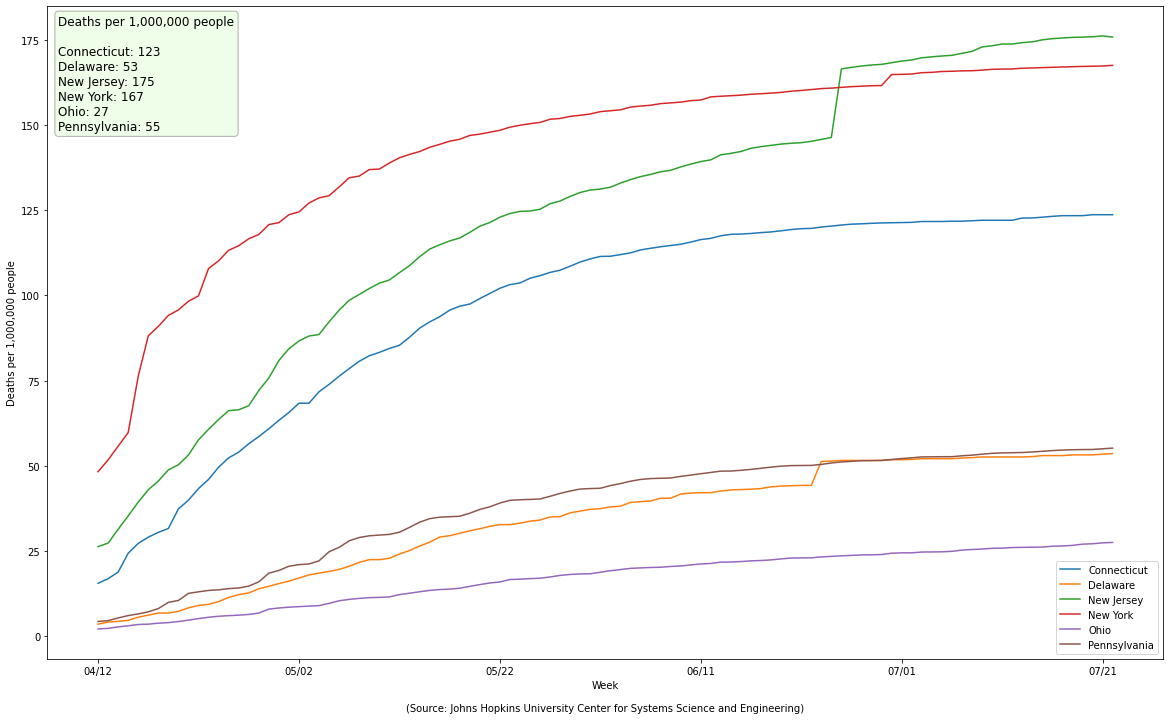

In [61]:
plot_states(df, ne_states, per_n=1_000_000, populations=populations, metric=MetricType.DEATHS)

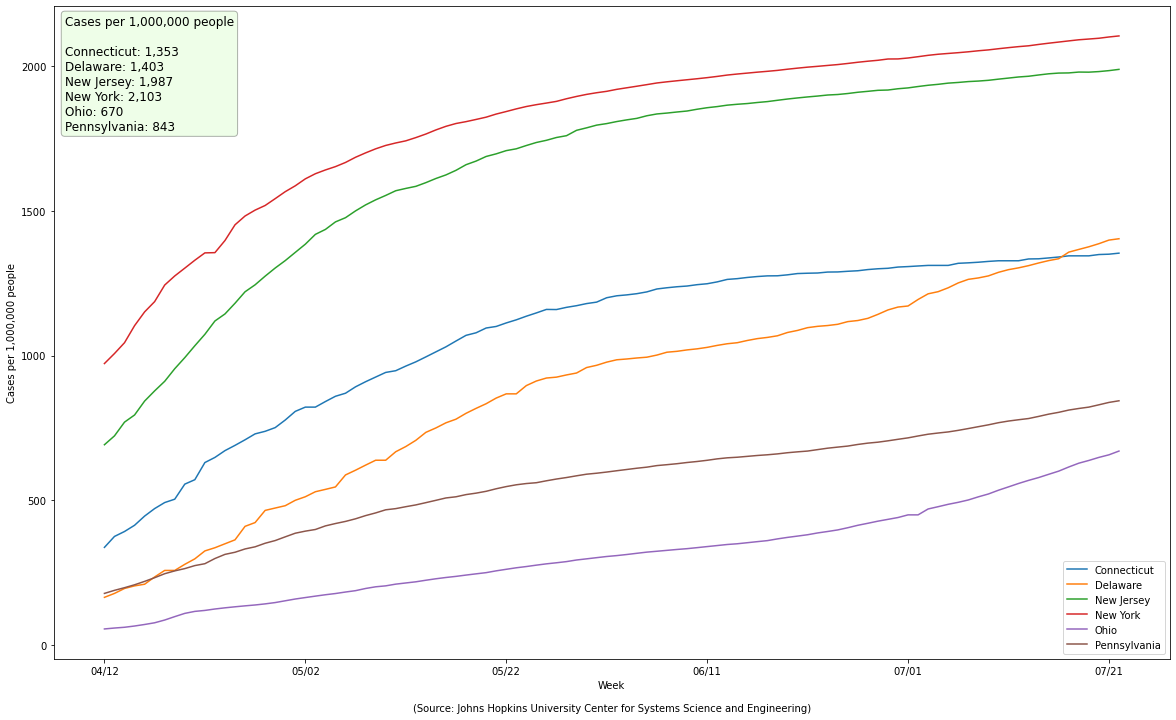

In [62]:
plot_states(df, ne_states, per_n=1_000_000, populations=populations, metric=MetricType.CASES)

### South and southwestern states

Data from some of the states hard hit in mid-2020.

In [63]:
s_sw_states = ('Arizona', 'Texas', 'Oklahoma', 'South Carolina', 'Utah', 'California', 'Florida')

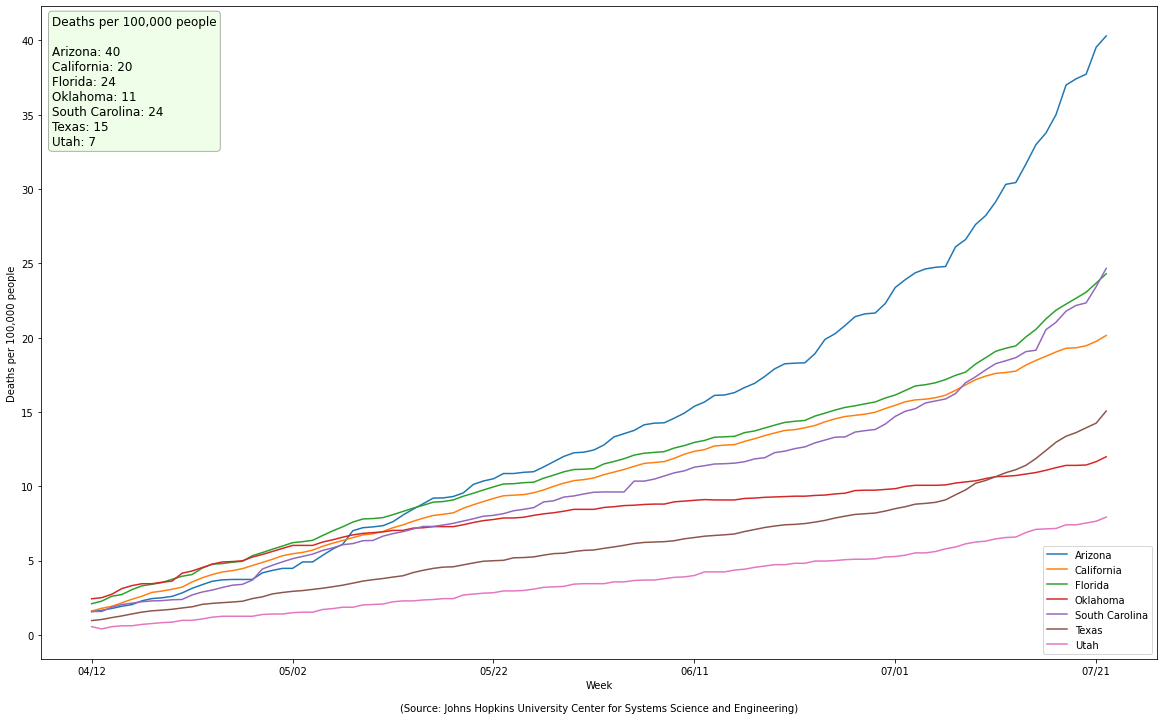

In [64]:
plot_states(df, s_sw_states, per_n=100_000, populations=populations, metric=MetricType.DEATHS)

How are some of these states doing, compared to Pennsylvania (my home state)?

In [57]:
s_sw_plus_pa = s_sw_states + ('Pennsylvania',)

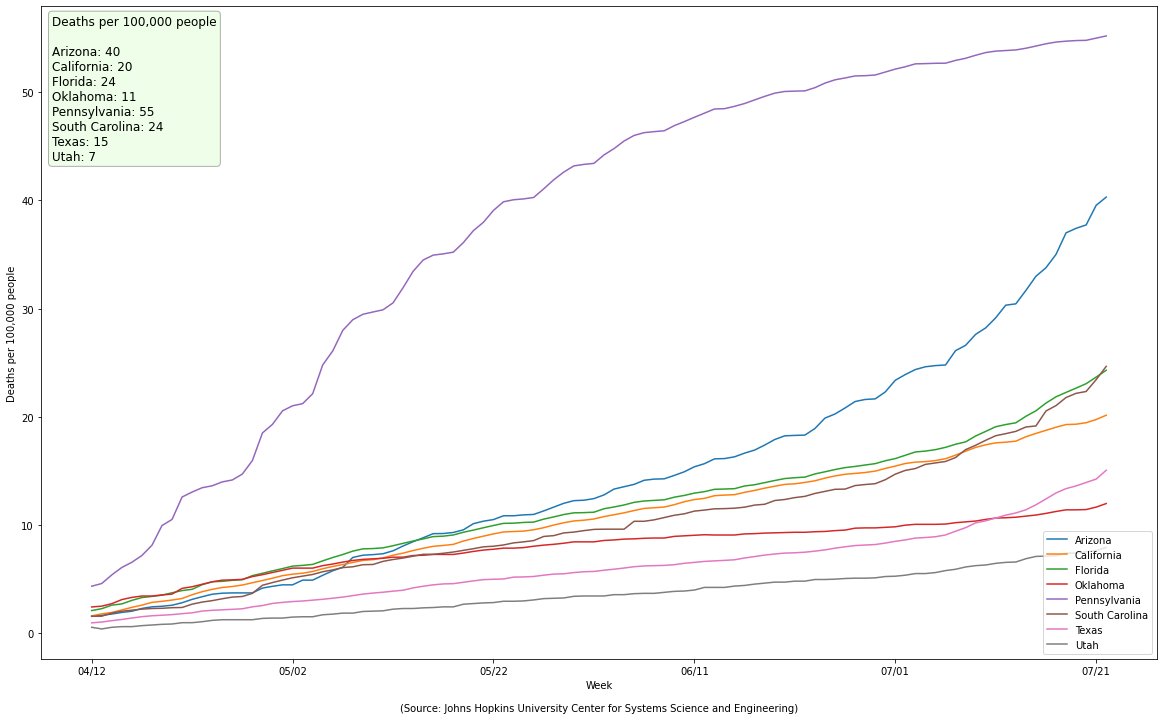

In [65]:
plot_states(df, s_sw_plus_pa, per_n=100_000, populations=populations, metric=MetricType.DEATHS)

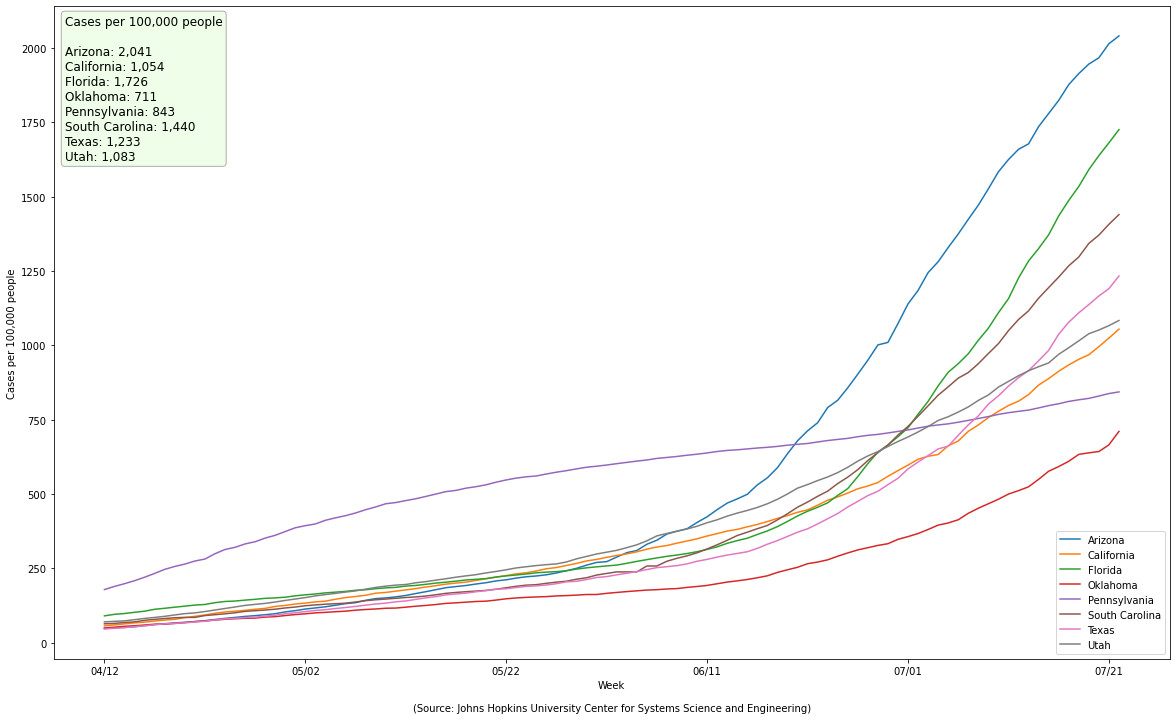

In [66]:
plot_states(df, s_sw_plus_pa, per_n=100_000, populations=populations, metric=MetricType.CASES)

## Per-capita rates for all states

In [162]:
def plot_states_per_capita(df, populations, metric=MetricType.DEATHS, figsize=(25, 12), show_us_per_capita=True):
    fig, ax = p.subplots(figsize=figsize)
    metric_col = METRIC_COLUMNS[metric]
    color = METRIC_COLORS[metric]
    label = METRIC_LABELS[metric]
    per_n = 1_000_000
    
    states = set(populations.keys()) - {'United States'}
    df_states = df.loc[df.Province_State.isin(states)].sort_values(by=['Date'], inplace=False)
    
    us_total = df_states[['Province_State', metric_col]].groupby(['Province_State']).max().sum()
    us_per_capita = get_per_capita_int(us_total, populations['United States'], per_n=per_n)

    df_states['Per_Capita'] = df_no_us.apply(
        lambda r: get_per_capita_float(r[metric_col], populations[r.Province_State], per_n=per_n),
        axis=1
    )

    df_grouped = df_states[['Province_State', 'Per_Capita']].groupby(['Province_State']).max()
    df_grouped.plot.bar(ax=ax, color=color)
    if show_us_per_capita:
        ax.axhline(us_per_capita, color="lightgray")
        ax.set_yticks(ax.get_yticks() + [us_per_capita])

    # Set the X and Y axis labels. Add the credit below the X label,
    # since it's a nice place to stash it without interfering with
    # the plot.
    xlabel = ("State\n\n"
              "(Source: Johns Hopkins University Center for Systems Science and Engineering)")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(f"{label} for {per_n:,} people")

    return (fig, ax)


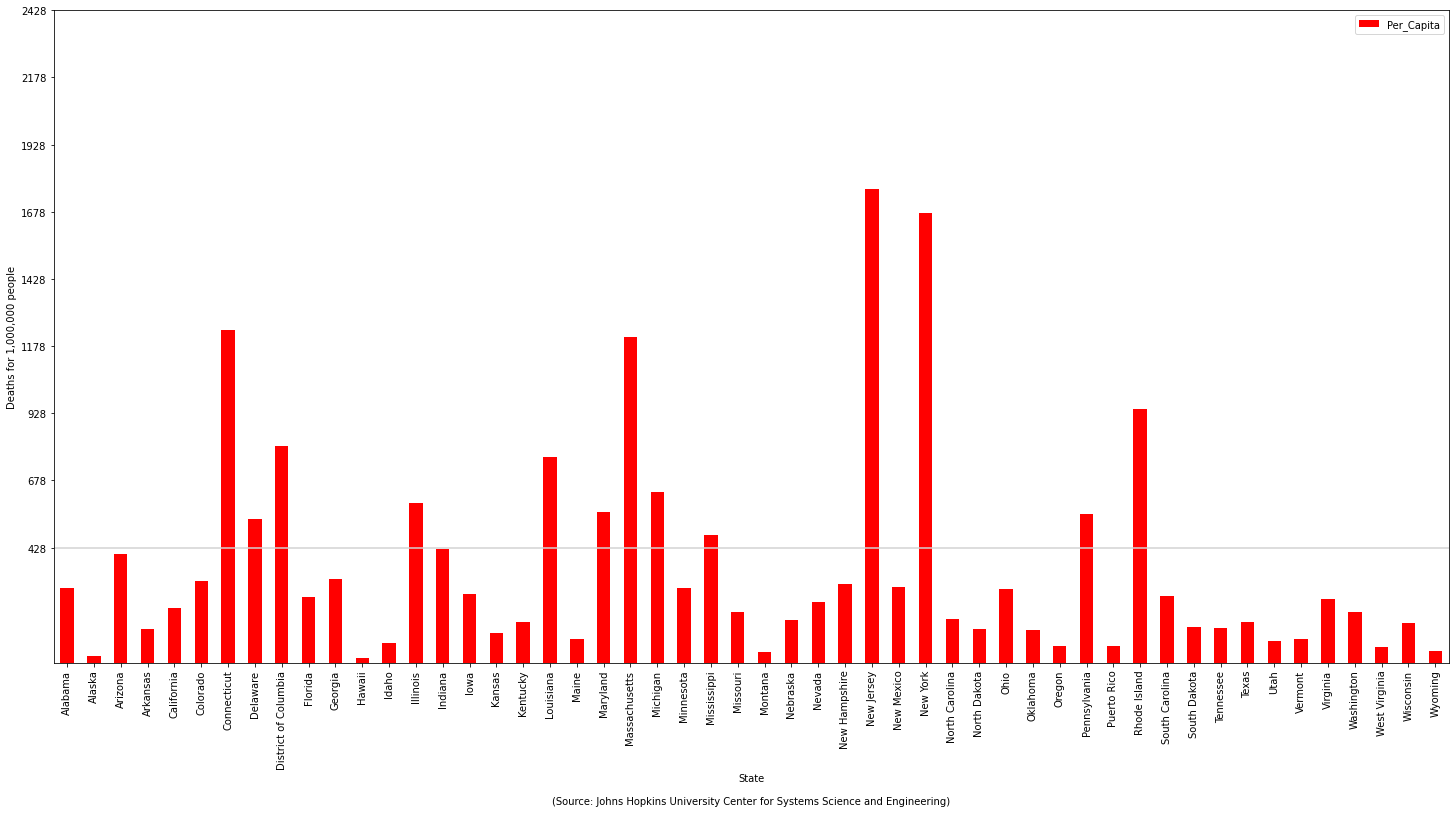

In [163]:
plot_states_per_capita(df, populations);

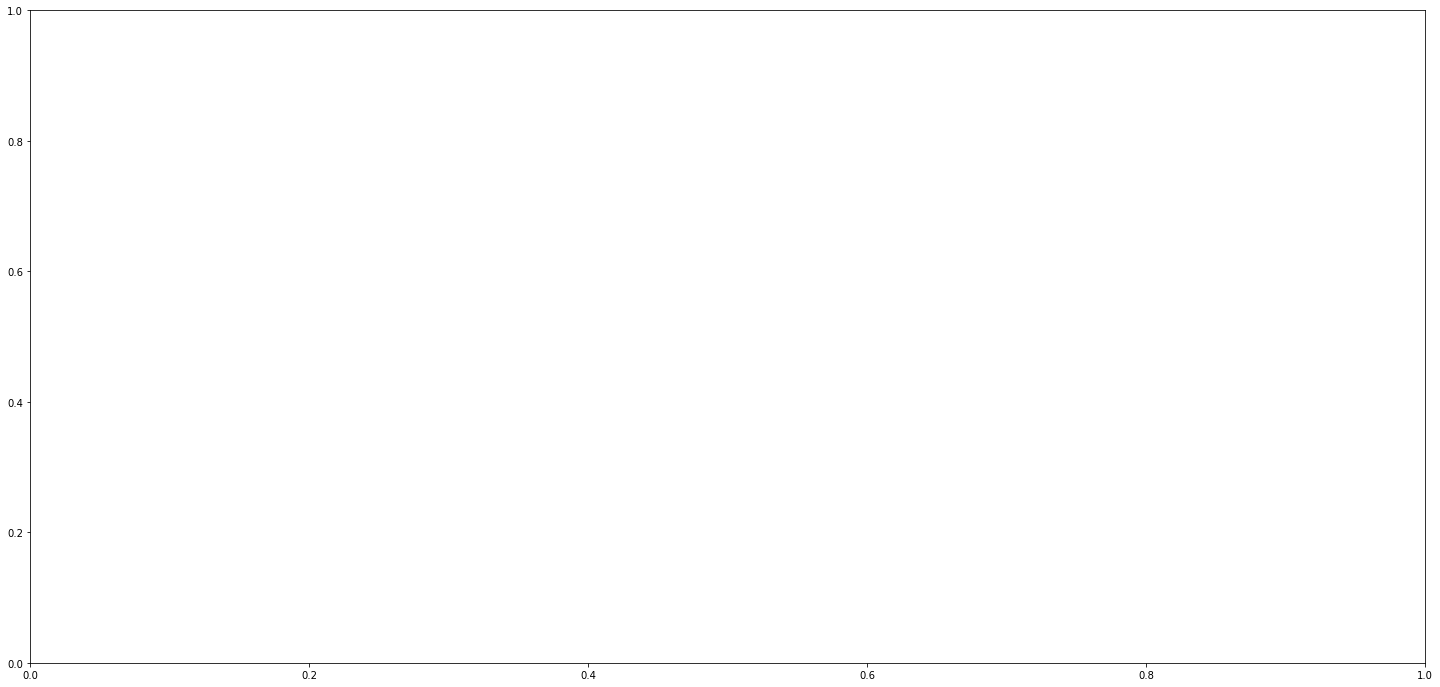

In [69]:
# Deaths

fig, ax = p.subplots(figsize=(25, 12))

df_no_us = df.loc[df.Province_State != 'United States'].sort_values(by=['Date'], inplace=False)
df_final_values = df['Deaths']
df_final_values

"""
bar_labels = []
max_value = 0
for state in sorted(populations.keys()):
    if state == 'United States':
        continue

    abbrev = state_info[state].abbreviation
    value = state_per_capita_deaths[state]
    ax.bar(abbrev, value)
    bar_labels.append(f"{value}")
    max_value = max(max_value, value)
    
ax.axhline(us_per_capita_deaths, color="lightgray")

ymax, stride = determine_ymax_and_stride(max_value)
ax.set_yticks(list(range(0, ymax))[::stride] + [us_per_capita_deaths])
ax.set_ylabel(f'Deaths per 100,000 people\n(rounded to the nearest integer)\nSince {jhu_starting_date}')
ax.set_xlabel('State or Territory')

# See https://stackoverflow.com/a/28931750
for rect, label in zip(ax.patches, bar_labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 1, label, ha='center', va='bottom')

textbox(ax, 0.01, 0.98, f"U.S. as a whole: {us_per_capita_deaths:,} deaths per 100,000")
fig.savefig(os.path.join(IMAGES_PATH, 'jhu-state-per-capita-deaths.png'))
"""
None

In [ ]:
# Cases

fig, ax = p.subplots(figsize=(25, 12))

bar_labels = []
max_value = 0
for state in sorted(populations.keys()):
    if state == 'United States':
        continue

    abbrev = state_info[state].abbreviation
    value = state_per_capita_cases[state]
    ax.bar(abbrev, value)
    bar_labels.append(f"{value}")
    max_value = max(max_value, value)
    
ax.axhline(us_per_capita_cases, color="lightgray")

ymax, stride = determine_ymax_and_stride(max_value)
ax.set_yticks(list(range(0, ymax))[::stride] + [us_per_capita_cases])
ax.set_ylabel(f'Cases per 100,000 people\n(rounded to the nearest integer)\nSince {jhu_starting_date}')
ax.set_xlabel('State or Territory')

# See https://stackoverflow.com/a/28931750
for rect, label in zip(ax.patches, bar_labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 1, label, ha='center', va='bottom')

textbox(ax, 0.01, 0.98, f"U.S. as a whole: {us_per_capita_cases:,} cases per 100,000")
fig.savefig(os.path.join(IMAGES_PATH, 'jhu-state-per-capita-cases.png'))